### Create a folder to save results

In [1]:
res_dir <- "analysis_results"
system(paste("mkdir -p ", res_dir))

# Load used libraries
library(dplyr)
library(tidyverse)
library(RColorBrewer)
library(patchwork)
library(car)
library(ggpubr)
library(rstatix)
library(xtable)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6     ✔ purrr   0.3.5
✔ tibble  3.1.8     ✔ stringr 1.4.1
✔ tidyr   1.2.1     ✔ forcats 0.5.2
✔ readr   2.1.3     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:purrr’:

    some


The following object is masked from ‘package:dplyr’:

    recode



Attaching package: ‘rstatix’


The following object is masked from ‘package:stats’:

    filter




### Save and load session

In [2]:
# save.image(file = file.path(res_dir, ".RData"))

In [3]:
# load(file = file.path(res_dir, ".RData"))

### Read in summary files

In [4]:
# Load data
df_dmf <- read.csv("../../perf_summary/dmf.csv", header = T)

# PPR
df_ppr <- read.csv("../../perf_summary/ppr_multiclass.csv", header = T)

# Eukaryote
# df_eukrep <- read.csv("./summary_eukrep.csv", header = T)
df_tiara <- read.csv("../../perf_summary/tiara.csv", header = T)
df_whokaryote <- read.csv("../../perf_summary/whokaryote.csv", header = T)

# Plasmid
df_plasflow <- read.csv("../../perf_summary/plasflow.csv", header = T)
df_ppr_plas <- read.csv("../../perf_summary/ppr_plasmid.csv", header = T)

# Prok Virus
df_vibrant <- read.csv("../../perf_summary/vibrant.csv", header = T)
df_ppr_vir <- read.csv("../../perf_summary/ppr_vir.csv", header = T)
df_dvf <- read.csv("../../perf_summary/dvf.csv", header = T)

# Prok and Euk Virus
df_virsorter <- read.csv("../../perf_summary/virsorter2.csv", header = T)


In [5]:
head(df_dmf, 2)
head(df_ppr_plas, 2)
head(df_dvf, 2)

,filename,category,f1_score,accuracy
,<chr>,<chr>,<dbl>,<dbl>
1,643_129_129_83_17,eukaryote,0.9818182,0.997003
2,643_129_129_83_17,eukaryote_virus,1.0000000,1.000000


,filename,f1_score,accuracy
,<chr>,<dbl>,<dbl>
1,643_129_129_83_17,0.6526946,0.8841159
2,600_150_150_80_20,0.6750630,0.8710000


,filename,f1_score,accuracy
,<chr>,<dbl>,<dbl>
1,643_129_129_83_17,0.5693069,0.8261738
2,600_150_150_80_20,0.6527778,0.8500000


### Tidy up PROK:EUK fractions through filenames

In [6]:
filename_df <- data.frame(filename=unique(df_dmf$filename))
count_df <- filename_df %>% separate(filename, into=c("Prok", "ProkVir", "Plas", "Euk", "EukVir"), sep="_", convert = T, extra = "drop")
metadata_df <- cbind(filename_df, count_df)
metadata_df <- metadata_df %>% 
  mutate(PROK=Prok+ProkVir+Plas, EUK=Euk+EukVir) %>%
  arrange(desc(PROK))
metadata_df[, "PROK_vs_EUK"] <- rep(c("9:1", "7:3", "5:5", "3:7", "1:9"), each = 4)
metadata_df <- metadata_df %>% 
  arrange(desc(PROK_vs_EUK), desc(Prok), .by_group = T)
metadata_df[, "Prok:ProkVir:Plas | Euk:EukVir"] <- rep(x = c("5:1:1 | 5:1", "4:1:1 | 4:1", "3:1:1 | 3:1", "2:1:1 | 2:1"), times = 5)
ds_order <- paste("DS", rownames(count_df), sep = "_")
metadata_df$Dataset_No = factor(ds_order, levels=ds_order)
metadata_df
# write.table(x = metadata_df, file = paste(res_dir, "/", "test_dataset_summary.tsv", sep = ""), sep = "\t", quote = F, col.names = NA)
print(xtable(metadata_df[, c(11, 2, 3, 4, 5, 6, 7, 8, 9, 10)], type = "latex"), file = paste(res_dir, "/", "test_dataset_summary.tex", sep = ""), include.rownames = F)

filename,Prok,ProkVir,Plas,Euk,EukVir,PROK,EUK,PROK_vs_EUK,Prok:ProkVir:Plas | Euk:EukVir,Dataset_No
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<fct>
643_129_129_83_17,643,129,129,83,17,901,100,9:1,5:1:1 | 5:1,DS_1
600_150_150_80_20,600,150,150,80,20,900,100,9:1,4:1:1 | 4:1,DS_2
540_180_180_75_25,540,180,180,75,25,900,100,9:1,3:1:1 | 3:1,DS_3
450_225_225_67_33,450,225,225,67,33,900,100,9:1,2:1:1 | 2:1,DS_4
500_100_100_250_50,500,100,100,250,50,700,300,7:3,5:1:1 | 5:1,DS_5
467_117_117_240_60,467,117,117,240,60,701,300,7:3,4:1:1 | 4:1,DS_6
420_140_140_225_75,420,140,140,225,75,700,300,7:3,3:1:1 | 3:1,DS_7
350_175_175_200_100,350,175,175,200,100,700,300,7:3,2:1:1 | 2:1,DS_8
357_71_71_417_83,357,71,71,417,83,499,500,5:5,5:1:1 | 5:1,DS_9


In [7]:
dataset_order_names <- as.character(metadata_df$filename)
dataset_order_names

[1] "643_129_129_83_17"   "600_150_150_80_20"   "540_180_180_75_25"  
 [4] "450_225_225_67_33"   "500_100_100_250_50"  "467_117_117_240_60" 
 [7] "420_140_140_225_75"  "350_175_175_200_100" "357_71_71_417_83"   
[10] "333_83_83_400_100"   "300_100_100_375_125" "250_125_125_333_167"
[13] "214_43_43_583_117"   "200_50_50_560_140"   "180_60_60_525_175"  
[16] "150_75_75_467_233"   "71_14_14_750_150"    "67_17_17_720_180"   
[19] "60_20_20_675_225"    "50_25_25_600_300"

# Plot test datasets sequence class composition

In [8]:
metadata_df_pct <- metadata_df %>% 
  select(Prok, ProkVir, Plas, Euk, EukVir, Dataset_No) %>%
  mutate(RowSum = Prok+ProkVir+Plas+Euk+EukVir) %>% 
  mutate(Prok_pct = Prok/RowSum, ProkVir_pct = ProkVir/RowSum, Plas_pct = Plas/RowSum, EukVir_pct = EukVir/RowSum, Euk_pct = Euk/RowSum) %>% 
  select(Dataset_No, Prok_pct, ProkVir_pct, Plas_pct, EukVir_pct, Euk_pct) %>% 
  tidyr::gather(Prok_pct:Euk_pct, key = Class, value = Percentage) %>%
  mutate(Class = factor(Class, levels=c("Plas_pct", "Prok_pct", "ProkVir_pct", "Euk_pct", "EukVir_pct")))

metadata_df_pct <- metadata_df_pct %>% mutate(Class=dplyr::recode(Class,
  "Plas_pct" = "Plasmid",
  "Prok_pct" = "Prokaryote",
  "ProkVir_pct" = "Prokaryote Virus",
  "Euk_pct" = "Eukaryote",
  "EukVir_pct" = "Eukaryote Virus"
))
head(metadata_df_pct, 2)

,Dataset_No,Class,Percentage
,<fct>,<fct>,<dbl>
1,DS_1,Prokaryote,0.6423576
2,DS_2,Prokaryote,0.6000000


In [9]:
colors <- brewer.pal(5, "Paired")
colors <- c("#FB9A99", "#A6CEE3", "#1F78B4", "#B2DF8A", "#33A02C")
colors

[1] "#FB9A99" "#A6CEE3" "#1F78B4" "#B2DF8A" "#33A02C"

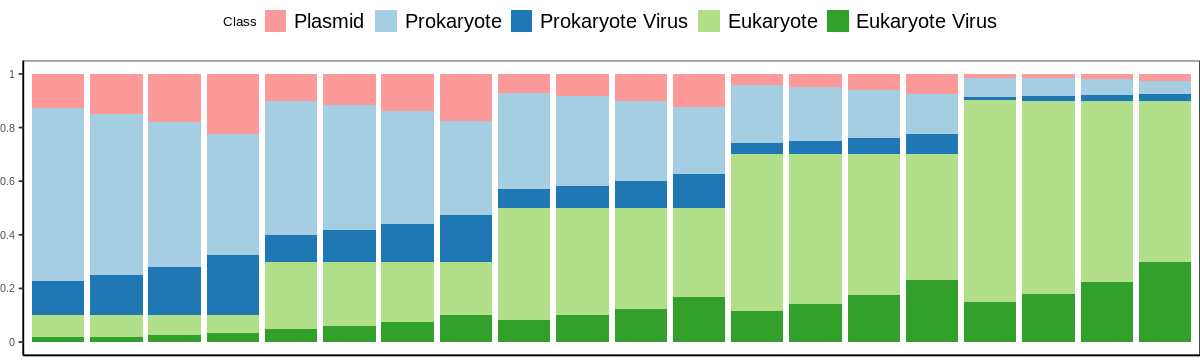

In [10]:
options(repr.plot.width=10, repr.plot.height=3)

ggplot(data = metadata_df_pct, aes(x=Dataset_No, y=Percentage, fill=Class)) + 
  geom_bar(position="stack", stat="identity") +
#   geom_text(aes(label = round(Percentage*100, 2)), position = position_stack(vjust = 0.5), size = 5) +
  #scale_fill_brewer(palette="Paired") + 
  scale_fill_manual(values=colors) +
  # scale_y_continuous(breaks = seq(0, 1, 0.1), labels = seq(0,1,0.1)) +
  scale_y_continuous(breaks = seq(0, 1, 0.2), labels = seq(0,1,0.2)) +
  coord_cartesian(ylim = c(0, 1)) + 
  labs(x="Dataset Number", y="Percentage") +
  theme_bw() + 
  theme(panel.background = element_blank(), 
       axis.line = element_line(colour = "black"), 
       # text = element_text(size = 20),
       text = element_text(size = 8),

       # axis.title.x = element_text(size=24, color="black", vjust=-1), 
       # axis.title.y = element_text(size=24, color="black"), 
      #  axis.title.x = element_text(size=8, color="black", vjust=-1),
      #  axis.title.y = element_text(size=8, color="black"),
      axis.title = element_blank(),

      # axis.text.x = element_text(angle = 45, hjust = 0.8, vjust=0.6, color="black"), 
      # axis.text.y = element_text(angle = 0, color="black"), 
      # panel.grid.minor.x = element_line(colour = "grey", size=0.2, linetype = 'dashed'), 
      # panel.grid.major.x = element_line(colour = "grey", size=0.2),
      # panel.grid.minor.y = element_line(colour = "grey", size = 0.2, linetype = 'dashed'),
      # panel.grid.major.y = element_line(colour = "grey", size=0.2),
      axis.text.x = element_blank(),
      axis.ticks.x = element_blank(),
      panel.grid = element_blank(),
      # axis.text = element_blank(),
      # axis.ticks = element_blank(),
      # panel.border = element_blank(),
      # axis.line = element_blank(),
       #  legend.position = "right", 
       legend.position = "top",
       # legend.text=element_text(size=20), 
       legend.text = element_text(size=12, color="black"),
       legend.key.size = unit(1,"line"), 
      #  plot.margin=unit(c(1,1,1,1),"cm")
       plot.margin=unit(c(0,0,0,0),"cm")

       ) 
ggsave(filename="test_dataset_composition_barplot.svg", # useDingbats=FALSE, 
       plot = last_plot(), path=res_dir, 
      #  scale = 1, width = 200, height = 100, units = "mm",
       scale = 1, width = 200, height = 30, units = "mm",
      bg = "transparent",
       dpi = 300, limitsize = FALSE)

# Comparison of Eukaryotic classification

In [11]:
# DeepMicrobeFinder Euk
df_dmf_euk <- df_dmf %>% filter(category == "eukaryote")
df_dmf_euk <- df_dmf_euk[match(dataset_order_names, df_dmf_euk$filename),]
rownames(df_dmf_euk) <- seq(0, 19)
head(df_dmf_euk, 2)
# Tiara Euk
df_tiara_euk <- df_tiara[match(dataset_order_names, df_tiara$filename),]
rownames(df_tiara_euk) <- seq(0, 19)
head(df_tiara_euk, 2)
# Whokaryote Euk
df_whokaryote_euk <- df_whokaryote[match(dataset_order_names, df_whokaryote$filename),]
rownames(df_whokaryote_euk) <- seq(0, 19)
head(df_whokaryote_euk, 2)

,filename,category,f1_score,accuracy
,<chr>,<chr>,<dbl>,<dbl>
0,643_129_129_83_17,eukaryote,0.9818182,0.997003
1,600_150_150_80_20,eukaryote,0.9937888,0.999000


,filename,f1_score,accuracy
,<chr>,<dbl>,<dbl>
0,643_129_129_83_17,0.9299363,0.989011
1,600_150_150_80_20,0.9271523,0.989000


,filename,f1_score,accuracy
,<chr>,<dbl>,<dbl>
0,643_129_129_83_17,0.5432099,0.9260739
1,600_150_150_80_20,0.5033113,0.9250000


In [12]:
# merge DeepMicrobeFinder and Tiara and Whokaryote
euk_df <- cbind(df_dmf_euk[, c("f1_score", "accuracy")], df_tiara_euk[, c("f1_score", "accuracy")], df_whokaryote_euk[, c("f1_score", "accuracy")])
colnames(euk_df) <- c("DMF_F1", "DMF_Acc", "Tiara_F1", "Tiara_Acc", "Whokaryote_F1", "Whokaryote_Acc")
ds_order <- paste("DS", rownames(euk_df), sep = "_")
euk_df$Dataset_No = factor(ds_order, levels=ds_order) 
head(euk_df, 2)

,DMF_F1,DMF_Acc,Tiara_F1,Tiara_Acc,Whokaryote_F1,Whokaryote_Acc,Dataset_No
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0,0.9818182,0.997003,0.9299363,0.989011,0.5432099,0.9260739,DS_0
1,0.9937888,0.999000,0.9271523,0.989000,0.5033113,0.9250000,DS_1


In [13]:
rects_2 <- data.frame(xmin = seq(4.5, 20, 8), 
                       xmax = seq(8.5, 20, 8))
head(rects_2, 2)

,xmin,xmax
,<dbl>,<dbl>
1,4.5,8.5
2,12.5,16.5


### - Plot accuracy and F1 score for DeepMicrobeFinder, Tiara and Whokaryote

,Dataset_No,Predictor,F1Score
,<fct>,<chr>,<dbl>
1,DS_0,DMF_F1,0.9818182
2,DS_1,DMF_F1,0.9937888


,Dataset_No,Predictor,Accuracy
,<fct>,<chr>,<dbl>
1,DS_0,DMF_Acc,0.997003
2,DS_1,DMF_Acc,0.999000


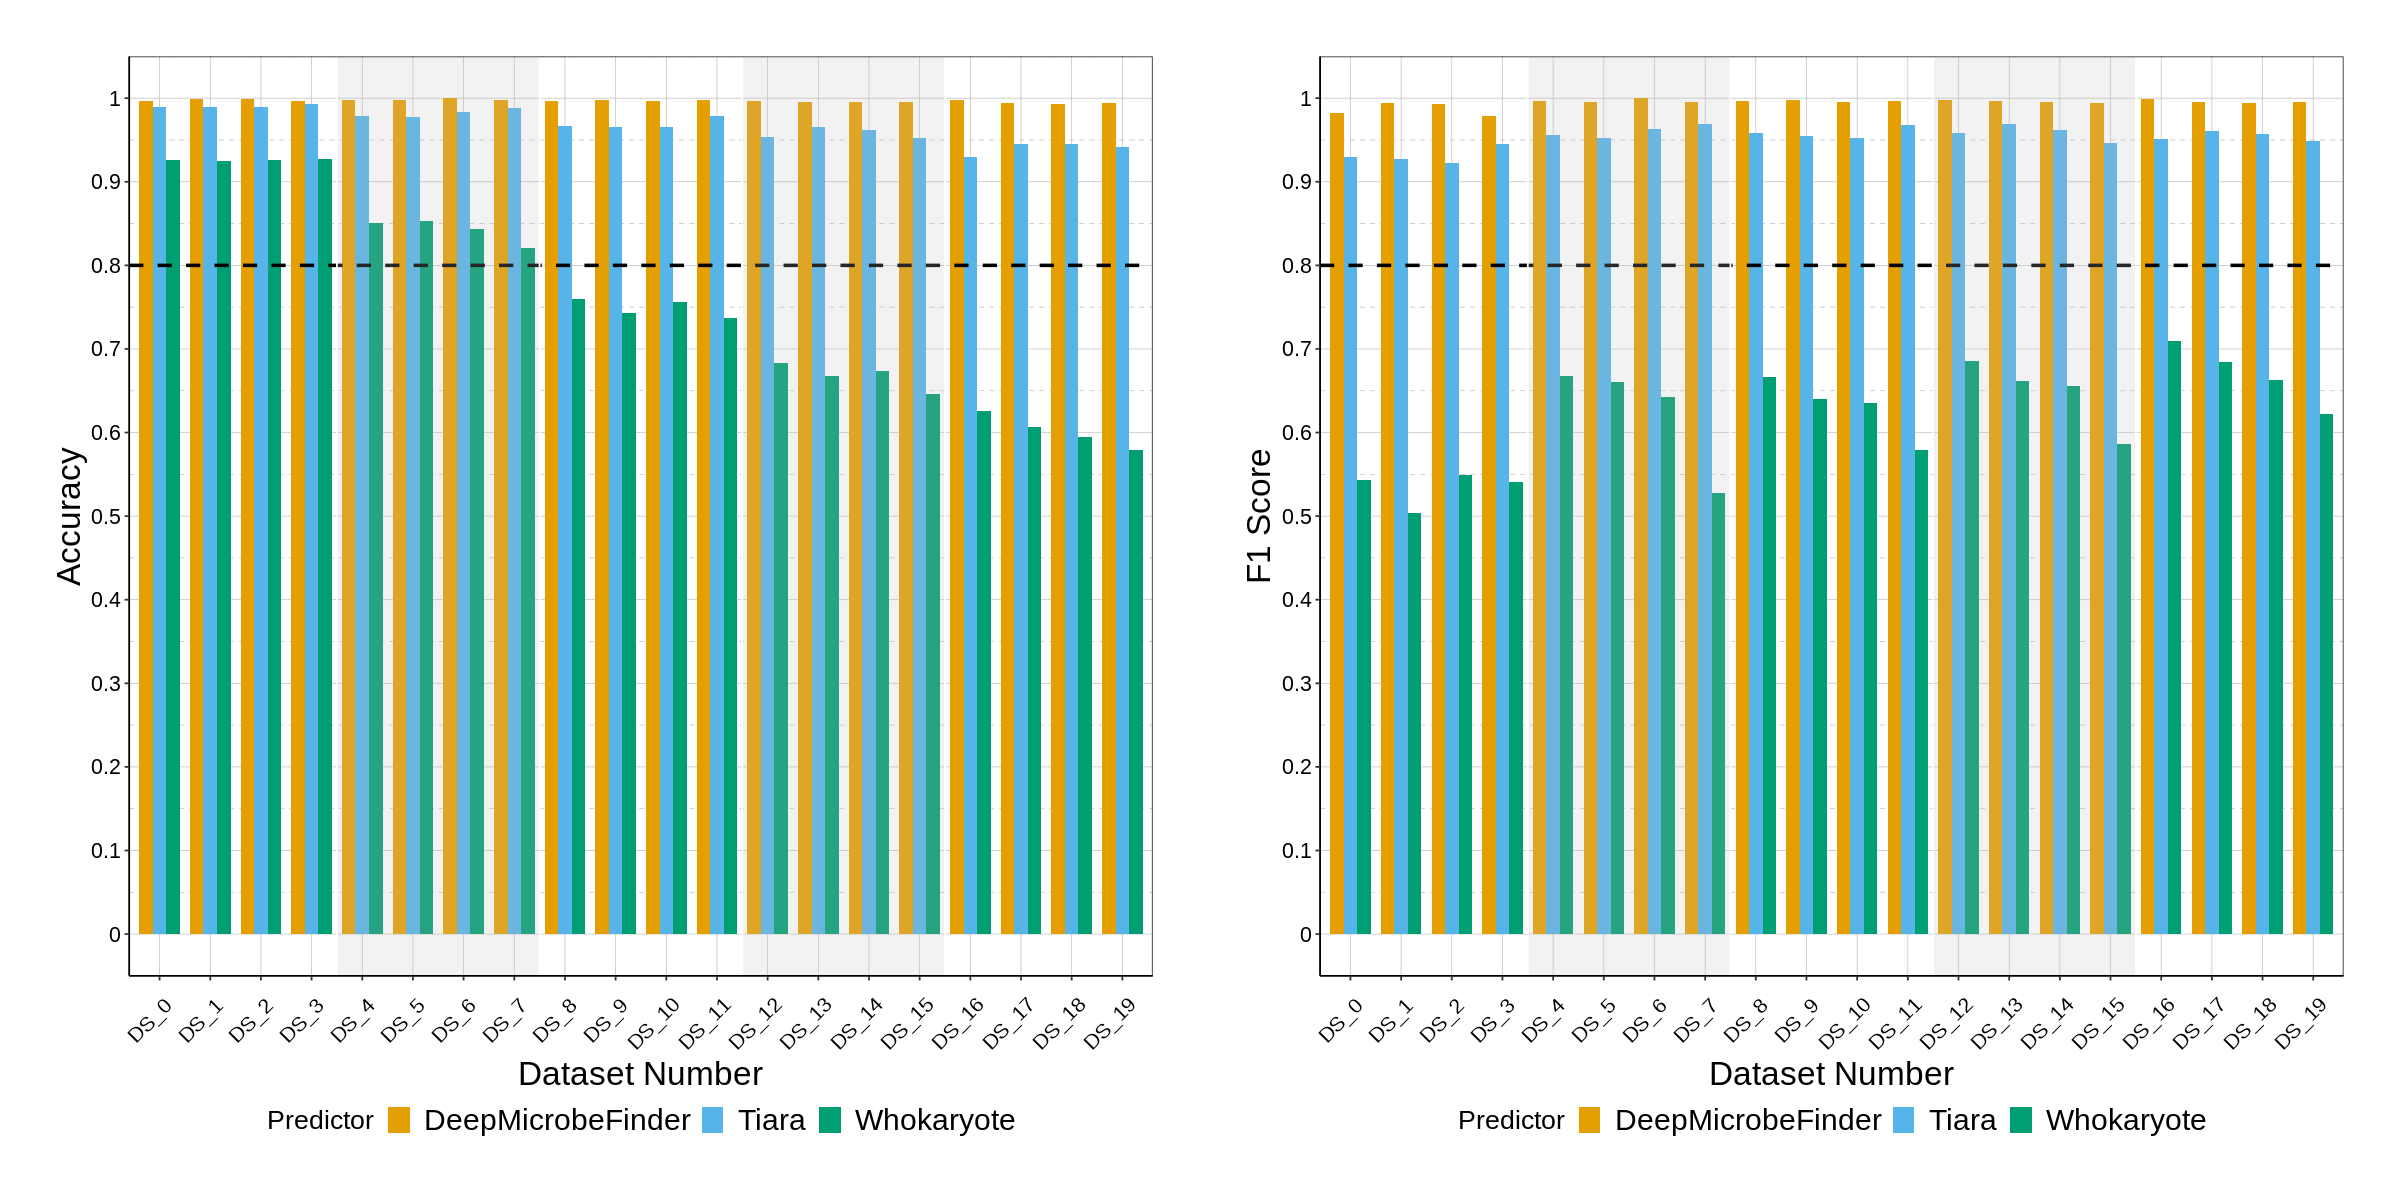

In [14]:
options(repr.plot.width=20, repr.plot.height=10)

# Euk F1 Score
euk_df_f1 <- euk_df %>% 
  select(Dataset_No, DMF_F1, Tiara_F1, Whokaryote_F1) %>% 
  tidyr::gather(-Dataset_No, key = "Predictor", value = "F1Score")
head(euk_df_f1, 2)

# #blind_colors <- c("orange2", "deepskyblue", "green", "yellow", "blue", "vermillion", "purple", "black")
blind_colors <- c("#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7", "#000000")

p_euk_f1 <- ggplot(euk_df_f1) + 
  geom_bar(aes(x=Dataset_No, y=F1Score, fill=Predictor), width=0.8, position = "dodge", stat="identity") +
  scale_fill_manual(name = "Predictor", values=blind_colors, labels = c("DeepMicrobeFinder", "Tiara", "Whokaryote")) + 
  scale_y_continuous(breaks = seq(0, 1, 0.1), labels = seq(0,1,0.1)) +
  geom_hline(yintercept=0.8, linetype="dashed", size=1, color = "black") +
  labs(x="Dataset Number", y="F1 Score") +
  coord_cartesian(ylim = c(0, 1)) + 
  theme_bw() + 
  geom_rect(data=rects_2, mapping=aes(xmin=xmin, xmax=xmax, ymin = -Inf, ymax = Inf), fill="grey", color="white", alpha = 0.2, inherit.aes = FALSE) +
  theme(panel.background = element_blank(), 
        axis.line = element_line(colour = "black"), 
        text = element_text(size = 16),
        axis.title.x = element_text(size=20, color="black", vjust=-1), 
        axis.title.y = element_text(size=20, color="black"), 
        axis.text.x = element_text(angle = 45, hjust = 0.8, vjust=0.6, color="black"), 
        axis.text.y = element_text(angle = 0, color="black"), 
        panel.grid.minor.x = element_line(colour = "grey", size=0.2, linetype = 'dashed'), 
        panel.grid.major.x = element_line(colour = "grey", size=0.2),
        panel.grid.minor.y = element_line(colour = "grey", size = 0.2, linetype = 'dashed'),
        panel.grid.major.y = element_line(colour = "grey", size=0.2),
        legend.position = "bottom", 
        legend.text=element_text(size=18), 
        legend.key.size = unit(1,"line"), 
        plot.margin=unit(c(1,1,1,1),"cm"))

# Euk Accuracy
euk_df_acc <- euk_df %>% 
  select(Dataset_No, DMF_Acc, Tiara_Acc, Whokaryote_Acc) %>% 
  tidyr::gather(-Dataset_No, key = "Predictor", value = "Accuracy")
head(euk_df_acc, 2)

p_euk_acc <- ggplot(data = euk_df_acc, aes(x=Dataset_No, y=Accuracy, fill=Predictor)) + 
  geom_bar(width=0.8, position = "dodge", stat="identity") +
  scale_fill_manual(name = "Predictor", values=blind_colors, labels = c("DeepMicrobeFinder", "Tiara", "Whokaryote")) + 
  scale_y_continuous(breaks = seq(0, 1, 0.1), labels = seq(0,1,0.1)) +
  geom_hline(yintercept=0.8, linetype="dashed", size=1, color = "black") +
  labs(x="Dataset Number", y="Accuracy") +
  coord_cartesian(ylim = c(0, 1)) + 
  theme_bw() + 
  geom_rect(data=rects_2, mapping=aes(xmin=xmin, xmax=xmax, ymin = -Inf, ymax = Inf), fill="grey", color="white", alpha = 0.2, inherit.aes = FALSE) +
  theme(panel.background = element_blank(), 
        axis.line = element_line(colour = "black"), 
        text = element_text(size = 16),
        axis.title.x = element_text(size=20, color="black", vjust=-1), 
        axis.title.y = element_text(size=20, color="black"), 
        axis.text.x = element_text(angle = 45, hjust = 0.8, vjust=0.6, color="black"), 
        axis.text.y = element_text(angle = 0, color="black"), 
        panel.grid.minor.x = element_line(colour = "grey", size=0.2, linetype = 'dashed'), 
        panel.grid.major.x = element_line(colour = "grey", size=0.2),
        panel.grid.minor.y = element_line(colour = "grey", size = 0.2, linetype = 'dashed'),
        panel.grid.major.y = element_line(colour = "grey", size=0.2),
        legend.position = "bottom", 
        legend.text=element_text(size=18), 
        legend.key.size = unit(1,"line"), 
        plot.margin=unit(c(1,1,1,1),"cm"))

p_euk_bar <- p_euk_acc + p_euk_f1
p_euk_bar

ggsave(filename="DMF_Tiara_Whokaryote_Euk_comparison_barplot.svg", # useDingbats=FALSE, 
       plot = last_plot(), path=res_dir, 
       scale = 1, width = 400, height = 200, units = "mm",
      bg = "transparent",
       dpi = 300, limitsize = FALSE)

### - t-test comparison of DeepMicrobeFinder and EukRep

In [15]:
# # t-test Accuracy
# pairwise.t.test(Accuracy ~ Predictor, data = euk_df_acc, p.adjust.method = "bonferroni", paired = T)

# # t-test F1 Scores
# pairwise.t.test(F1Score ~ Predictor, data = euk_df_f1, p.adjust.method = "bonferroni", paired = T)

**Fengzhu:** 

Since the evaluation is done on the same datasets, a **paired t-test** should be used if the differences are normally distributed. If not, the **Wilcoxon signed rank test** should be used. Please confirm.

- check for normality

In [16]:
# options(repr.plot.width=16, repr.plot.height=6)

# acc_diff <- euk_df$DMF_Acc - euk_df$EukRep_Acc
# f1_diff <- euk_df$DMF_F1 - euk_df$EukRep_F1

# #euk_diff <- data.frame(acc=acc_diff, f1=f1_diff)
# #euk_diff <- euk_diff %>%
# #    tidyr::gather(acc:f1, key = "Metrics", value = "Scores")
# #head(euk_diff, 2)
# #ggplot(euk_diff, aes(sample=Scores, group=Metrics)) + 
# #    stat_qq() + facet_wrap(~Metrics)

# layout(matrix(c(1,2), 1, 2, byrow = TRUE), widths=c(1,1), heights=c(1,1))
# a <- qqp(acc_diff);
# b <- qqp(f1_diff);

In [17]:
# # paired-sample Wilcoxon test on Accuracy
# wilcox.test(Accuracy ~ Predictor, data = euk_df_acc, paired = TRUE)

# # paired-sample Wilcoxon test on Accuracy F1 Scores
# wilcox.test(F1Score ~ Predictor, data = euk_df_f1, paired = TRUE)

In [18]:
# pairwise.wilcox.test(euk_df_acc$Accuracy, euk_df_acc$Predictor, p.adjust.method = "bonferroni", alternative = "less")
# pairwise.wilcox.test(euk_df_f1$F1Score, euk_df_f1$Predictor, p.adjust.method = "bonferroni", alternative = "less")

### - Compare means of accuracy and f1 scores by Wilcoxon-test

Warning message in wilcox.test.default(c(0.997002997002997, 0.999, 0.999, 0.997, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.997002997002997, 0.999, 0.999, 0.997, :
“cannot compute exact p-value with ties”


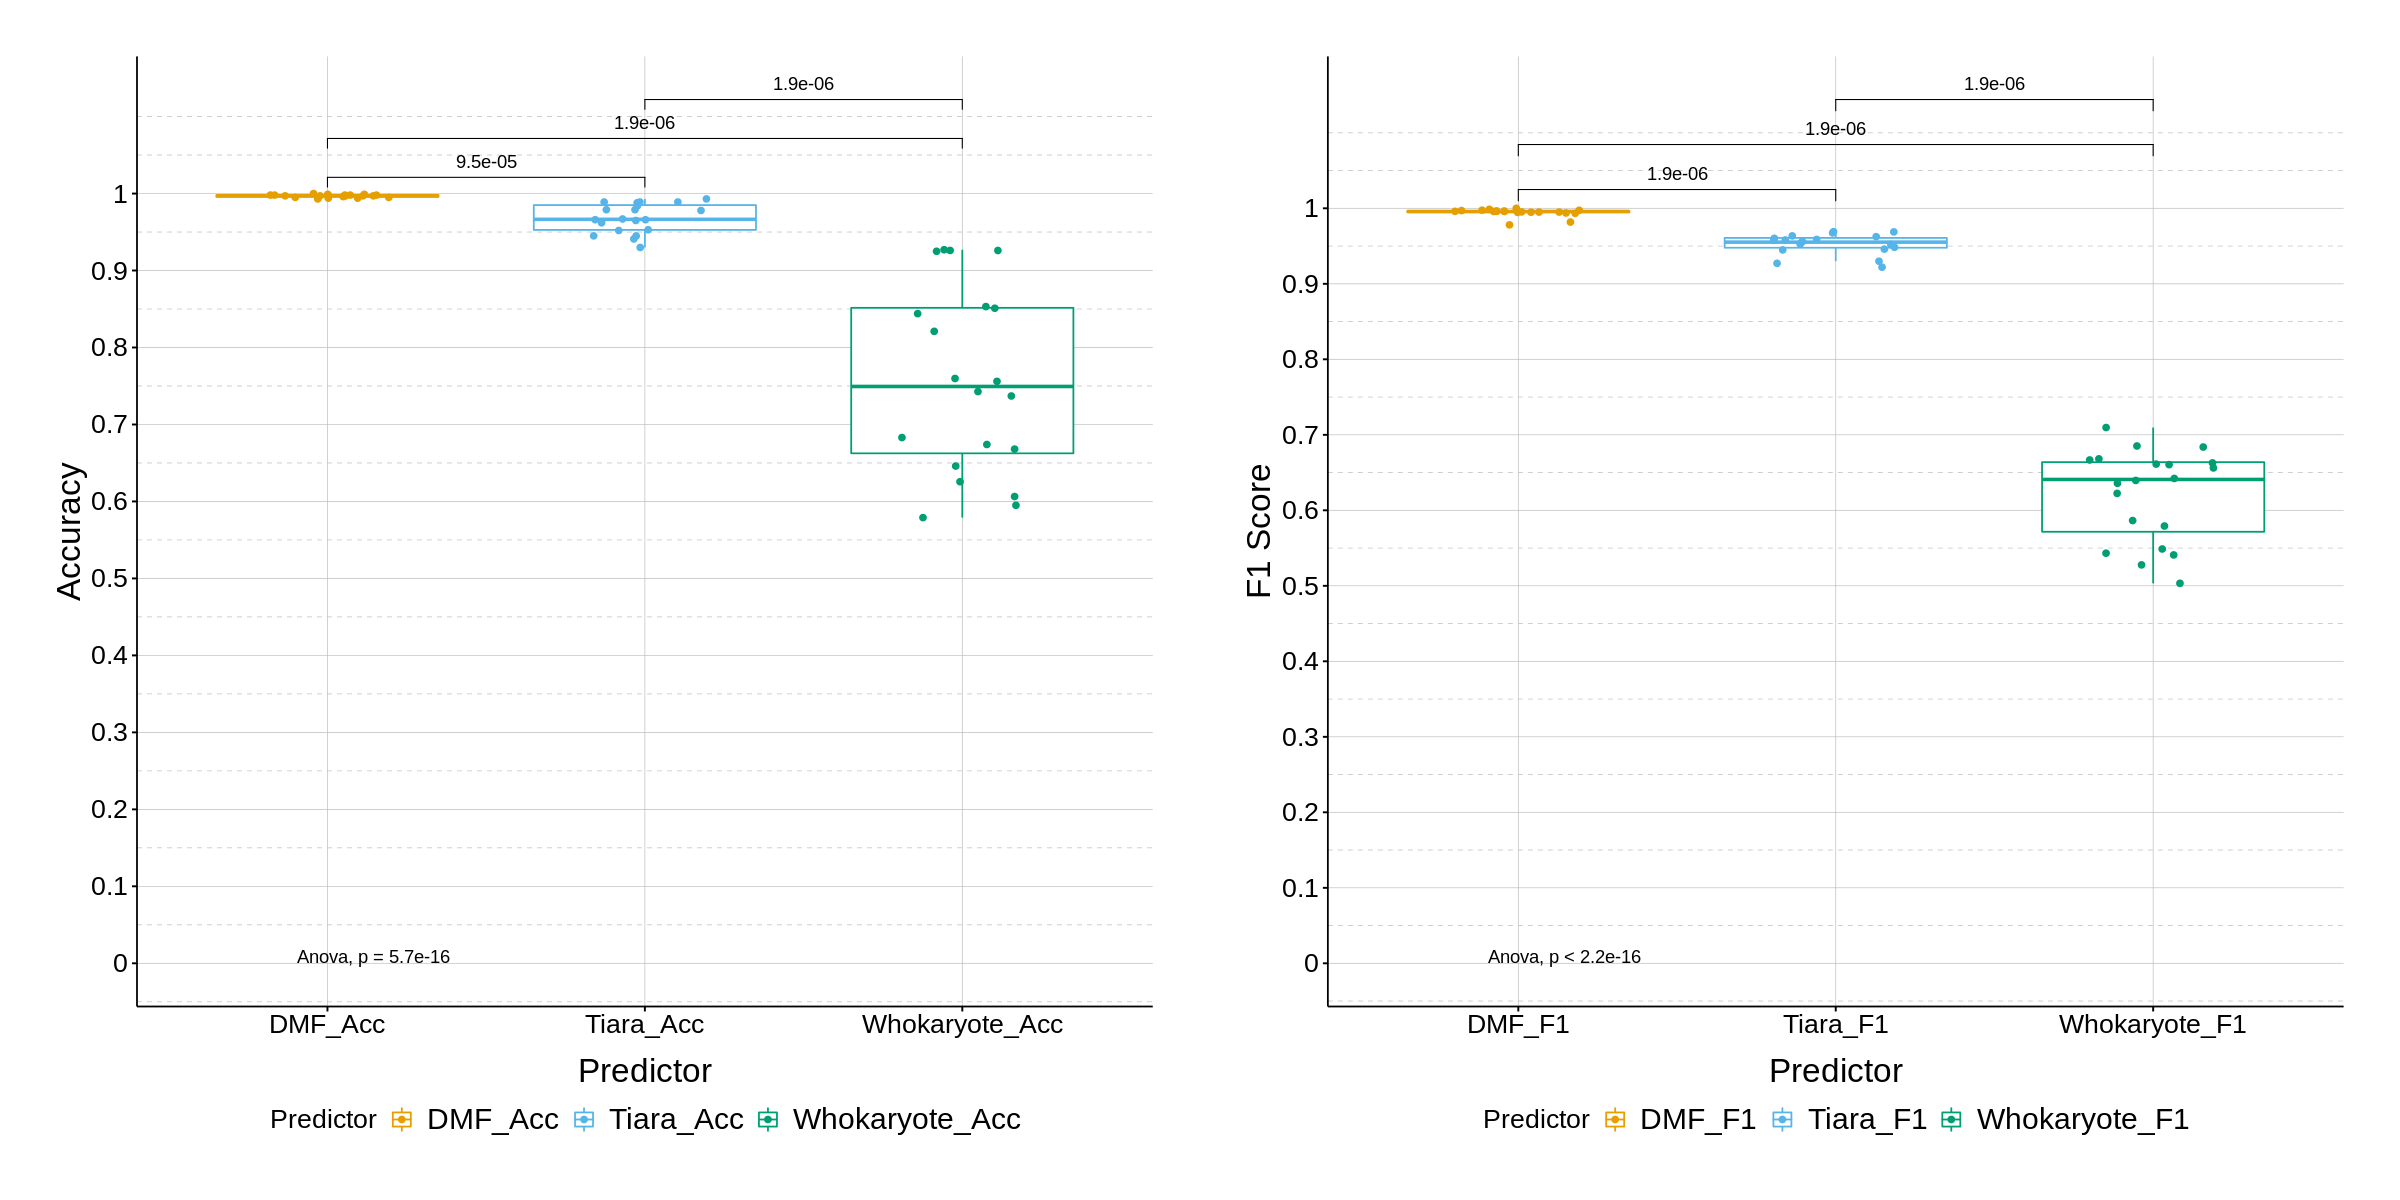

In [19]:
options(repr.plot.width=20, repr.plot.height=10)

#blind_colors <- c("orange2", "deepskyblue", "green", "yellow", "blue", "vermillion", "purple", "black")
blind_colors <- c("#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7", "#000000")
my_comparisons <- list(c("DMF_Acc", "Tiara_Acc"), c("DMF_Acc", "Whokaryote_Acc"), c("Tiara_Acc", "Whokaryote_Acc"))
p_euk_acc_box <- ggboxplot(euk_df_acc, x = "Predictor", y = "Accuracy", 
       color = "Predictor", add="jitter",
       palette = blind_colors) +
  stat_compare_means(comparisons = my_comparisons,  method = "wilcox.test", paired = TRUE) + # Add pairwise comparisons p-value
  #stat_compare_means(label.y = 0.5)     # Add global p-value
  stat_compare_means(method = "anova", label.y = 0.) +    # Add global p-value
  labs(x="Predictor", y="Accuracy") + 
  scale_y_continuous(breaks = seq(0, 1, 0.1), labels = seq(0,1,0.1)) +
  theme(panel.background = element_blank(), 
        axis.line = element_line(colour = "black"), 
        text = element_text(size = 16),
        axis.title.x = element_text(size=20, color="black", vjust=-1), 
        axis.title.y = element_text(size=20, color="black"), 
        axis.text.x = element_text(angle = 0, color="black"), 
        axis.text.y = element_text(angle = 0, color="black"), 
        panel.grid.minor.x = element_line(colour = "grey", size=0.2, linetype = 'dashed'), 
        panel.grid.major.x = element_line(colour = "grey", size=0.2),
        panel.grid.minor.y = element_line(colour = "grey", size = 0.2, linetype = 'dashed'),
        panel.grid.major.y = element_line(colour = "grey", size=0.2),
        legend.position = "bottom", 
        legend.text=element_text(size=18), 
        legend.key.size = unit(1,"line"), 
        plot.margin=unit(c(1,1,1,1),"cm"))

my_comparisons <- list( c("DMF_F1", "Tiara_F1"), c("DMF_F1", "Whokaryote_F1"), c("Tiara_F1", "Whokaryote_F1"))
p_euk_f1_box <- ggboxplot(euk_df_f1, x = "Predictor", y = "F1Score",
         color = "Predictor", add="jitter",
         palette = blind_colors) +
  stat_compare_means(comparisons = my_comparisons,  method = "wilcox.test", paired = TRUE) + # Add pairwise comparisons p-value
  #stat_compare_means(label.y = 0.5)     # Add global p-value
  stat_compare_means(method = "anova", label.y = 0.) +    # Add global p-value
  labs(x="Predictor", y="F1 Score") + 
  scale_y_continuous(breaks = seq(0, 1, 0.1), labels = seq(0,1,0.1)) +
  theme(panel.background = element_blank(), 
        axis.line = element_line(colour = "black"), 
        text = element_text(size = 16),
        axis.title.x = element_text(size=20, color="black", vjust=-1), 
        axis.title.y = element_text(size=20, color="black"), 
        axis.text.x = element_text(angle = 0, color="black"), 
        axis.text.y = element_text(angle = 0, color="black"), 
        panel.grid.minor.x = element_line(colour = "grey", size=0.2, linetype = 'dashed'), 
        panel.grid.major.x = element_line(colour = "grey", size=0.2),
        panel.grid.minor.y = element_line(colour = "grey", size = 0.2, linetype = 'dashed'),
        panel.grid.major.y = element_line(colour = "grey", size=0.2),
        legend.position = "bottom", 
        legend.text=element_text(size=18), 
        legend.key.size = unit(1,"line"), 
        plot.margin=unit(c(1,1,1,1),"cm"))

p_euk_box <- p_euk_acc_box + p_euk_f1_box
p_euk_box

ggsave(filename="DMF_Tiara_Whok_Euk_comparison_boxplot.svg", # useDingbats=FALSE, 
       plot = last_plot(), path=res_dir, 
       scale = 1, width = 400, height = 200, units = "mm",
       dpi = 300, limitsize = FALSE)

### - summary of Accuracy and F1-Score for Eukaryotic contig classification

In [20]:
# summary of accuracy
euk_df_acc %>% 
  group_by(Predictor) %>% 
  summarise(mean=mean(Accuracy), var=var(Accuracy), sd=sd(Accuracy))

# summary of f1 score
euk_df_f1 %>% 
  group_by(Predictor) %>% 
  summarise(mean=mean(F1Score), var=var(F1Score), sd=sd(F1Score))

Predictor,mean,var,sd
<chr>,<dbl>,<dbl>,<dbl>
DMF_Acc,0.9969002,3.461099e-06,0.001860403
Tiara_Acc,0.9679975,3.534729e-04,0.018800876
Whokaryote_Acc,0.7572871,1.447910e-02,0.120329145


Predictor,mean,var,sd
<chr>,<dbl>,<dbl>,<dbl>
DMF_F1,0.9944435,0.0000273386,0.005228633
Tiara_F1,0.9525284,0.0001767082,0.013293163
Whokaryote_F1,0.6211800,0.0037148586,0.060949640


# Comparison of Plasmid classification

In [21]:
# DeepMicrobeFinder Plasmid
df_dmf_plas <- df_dmf %>% filter(category == "plasmid")
df_dmf_plas <- df_dmf_plas[match(dataset_order_names, df_dmf_plas$filename),]
rownames(df_dmf_plas) <- seq(0, 19)
head(df_dmf_plas, 2)

# PlasFlow Plasmid
df_plasflow_plas <- df_plasflow[match(dataset_order_names, df_plasflow$filename),]
rownames(df_plasflow_plas) <- seq(0, 19)
head(df_plasflow_plas, 2)

# PPR-Meta Plasmid
df_ppr_plas <- df_ppr_plas[match(dataset_order_names, df_ppr_plas$filename),]
rownames(df_ppr_plas) <- seq(0, 19)
head(df_ppr_plas, 2)

# merge DeepMicrobeFinder, PlasFlow and PPR-Meta
plas_df <- cbind(df_dmf_plas[, c("f1_score", "accuracy")], df_plasflow_plas[, c("f1_score", "accuracy")], df_ppr_plas[, c("f1_score", "accuracy")])
colnames(plas_df) <- c("DMF_F1", "DMF_Acc", "PlasFlow_F1", "PlasFlow_Acc", "PPR_F1", "PPR_Acc")
ds_order <- paste("DS", rownames(plas_df), sep = "_")
plas_df$Dataset_No = factor(ds_order, levels=ds_order) 
head(plas_df, 2)

,filename,category,f1_score,accuracy
,<chr>,<chr>,<dbl>,<dbl>
0,643_129_129_83_17,plasmid,0.8857143,0.968032
1,600_150_150_80_20,plasmid,0.8963415,0.966000


,filename,f1_score,accuracy
,<chr>,<dbl>,<dbl>
0,643_129_129_83_17,0.6140845,0.8631369
1,600_150_150_80_20,0.6047619,0.8340000


,filename,f1_score,accuracy
,<chr>,<dbl>,<dbl>
0,643_129_129_83_17,0.6526946,0.8841159
1,600_150_150_80_20,0.6750630,0.8710000


,DMF_F1,DMF_Acc,PlasFlow_F1,PlasFlow_Acc,PPR_F1,PPR_Acc,Dataset_No
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0,0.8857143,0.968032,0.6140845,0.8631369,0.6526946,0.8841159,DS_0
1,0.8963415,0.966000,0.6047619,0.8340000,0.6750630,0.8710000,DS_1


### - plot accuracy and F1 score for DeepMicrobeFinder, PPR-Meta and PlasFlow

,Dataset_No,Predictor,F1Score
,<fct>,<chr>,<dbl>
1,DS_0,DMF_F1,0.8857143
2,DS_1,DMF_F1,0.8963415


,Dataset_No,Predictor,Accuracy
,<fct>,<chr>,<dbl>
1,DS_0,DMF_Acc,0.968032
2,DS_1,DMF_Acc,0.966000


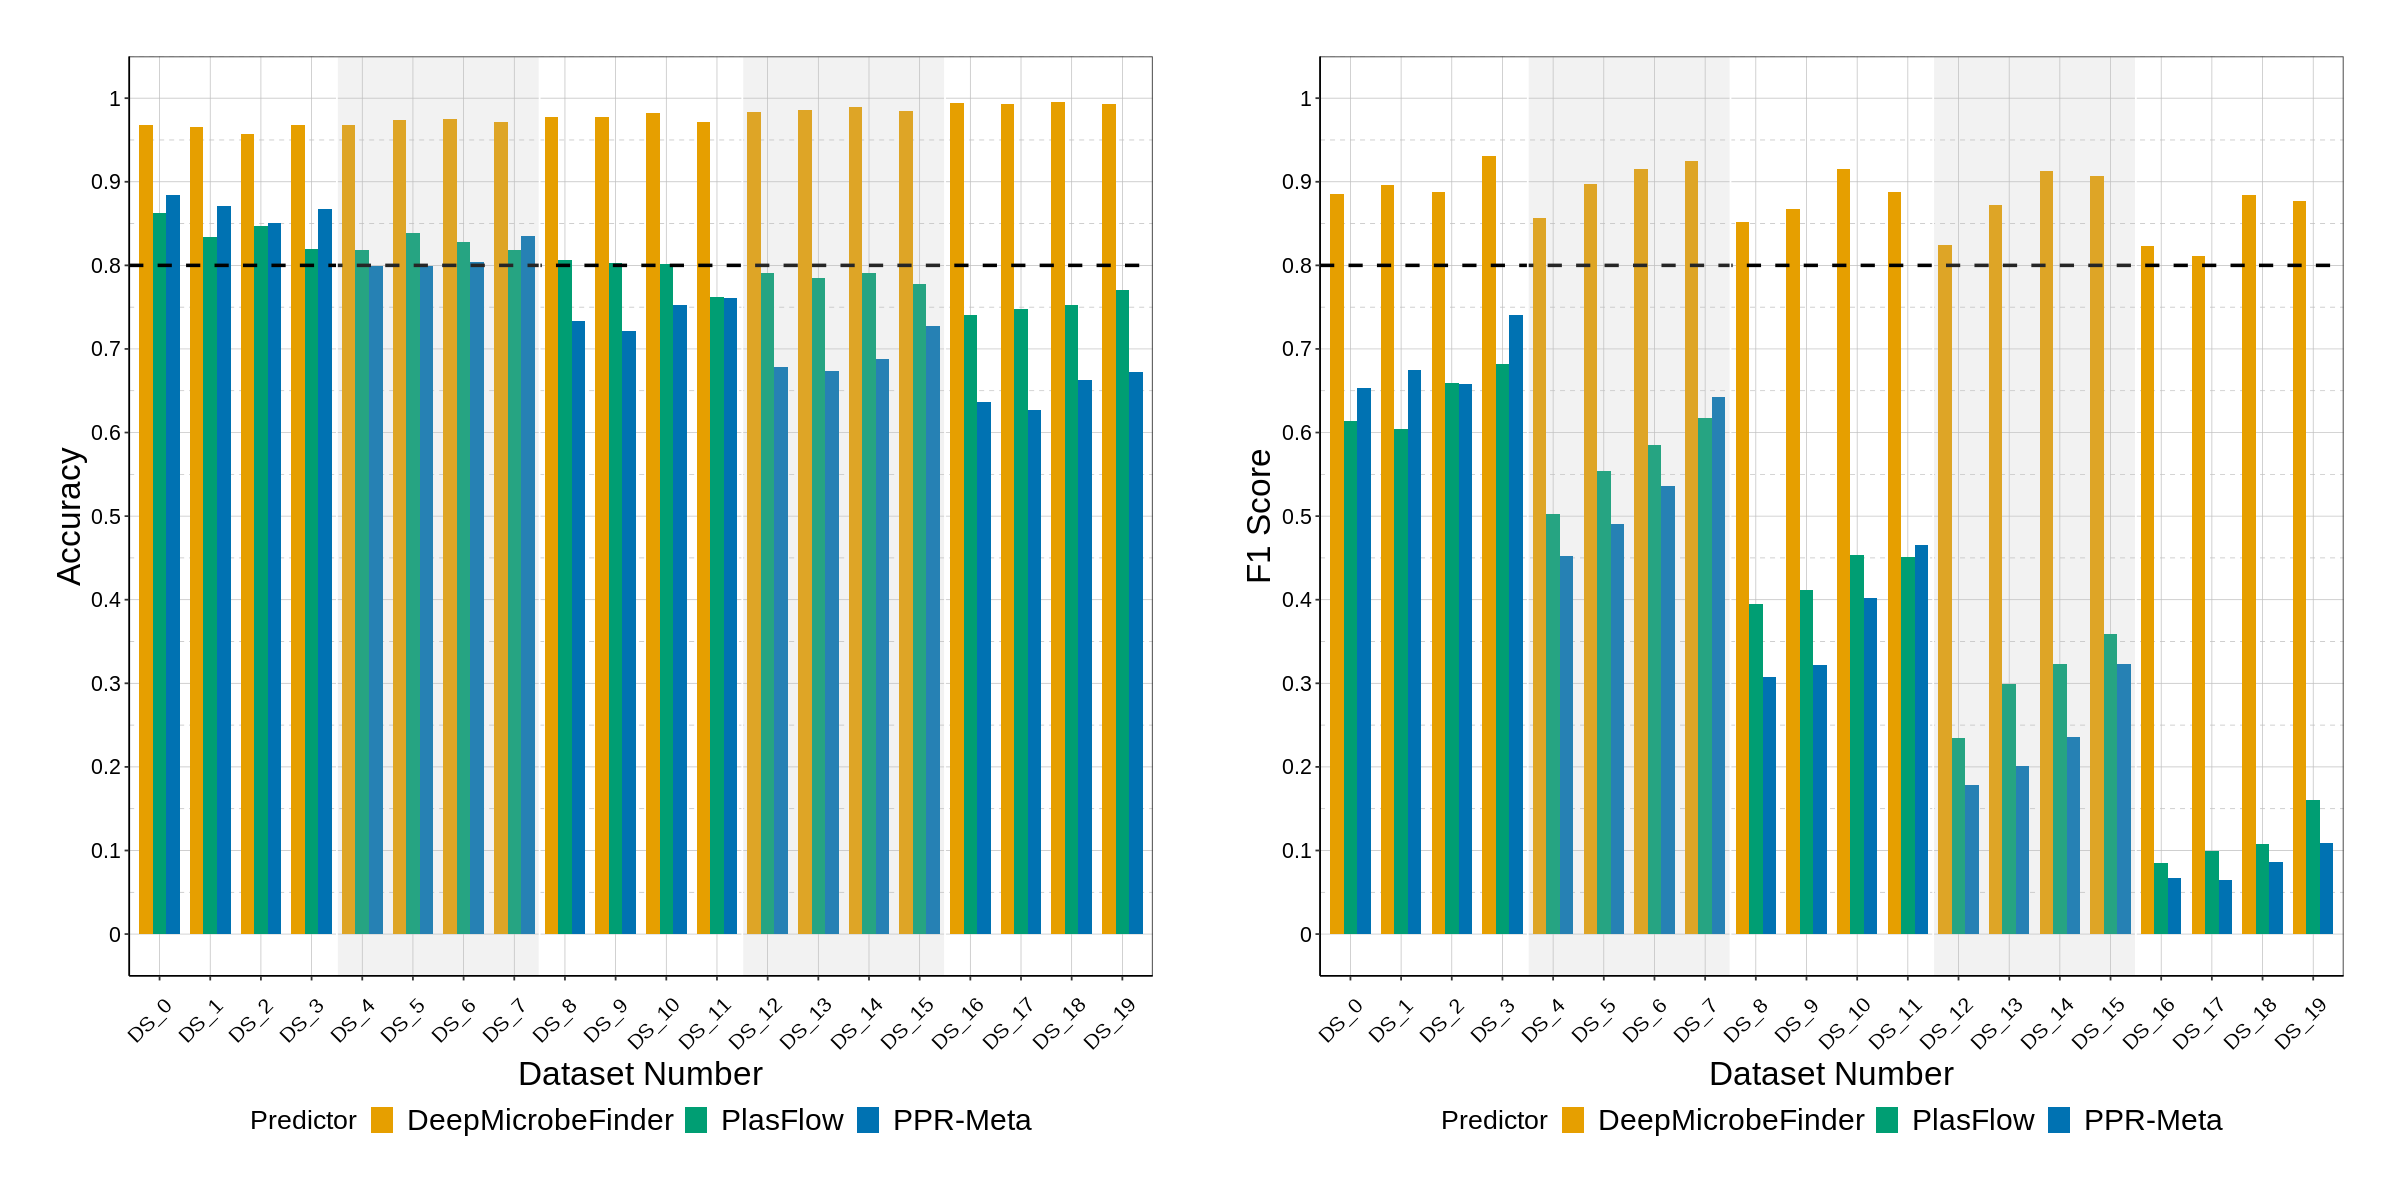

In [22]:
options(repr.plot.width=20, repr.plot.height=10)

# Plasmid F1 Score
plas_df_f1 <- plas_df %>% 
  select(Dataset_No, DMF_F1, PlasFlow_F1, PPR_F1) %>% 
  tidyr::gather(-Dataset_No, key = "Predictor", value = "F1Score")
head(plas_df_f1, 2)

#blind_colors <- c("orange2", "green", "blue", "vermillion", "purple", "black")
blind_colors <- c("#E69F00", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#000000")

p_plas_f1 <- ggplot(data = plas_df_f1, aes(x=Dataset_No, y=F1Score, fill=Predictor)) + 
  geom_bar(width=0.8, position = "dodge", stat="identity") +
  scale_fill_manual(name = "Predictor", values=blind_colors, labels = c("DeepMicrobeFinder", "PlasFlow", "PPR-Meta")) + 
  scale_y_continuous(breaks = seq(0, 1, 0.1), labels = seq(0,1,0.1)) +
  geom_hline(yintercept=0.8, linetype="dashed", size=1, color = "black") +
  labs(x="Dataset Number", y="F1 Score") +
  coord_cartesian(ylim = c(0, 1)) + 
  theme_bw() + 
  geom_rect(data=rects_2, mapping=aes(xmin=xmin, xmax=xmax, ymin = -Inf, ymax = Inf), fill="grey", color="white", alpha = 0.2, inherit.aes = FALSE) +
  theme(panel.background = element_blank(), 
        axis.line = element_line(colour = "black"), 
        text = element_text(size = 16),
        axis.title.x = element_text(size=20, color="black", vjust=-1), 
        axis.title.y = element_text(size=20, color="black"), 
        axis.text.x = element_text(angle = 45, hjust = 0.8, vjust=0.6, color="black"), 
        axis.text.y = element_text(angle = 0, color="black"), 
        panel.grid.minor.x = element_line(colour = "grey", size=0.2, linetype = 'dashed'), 
        panel.grid.major.x = element_line(colour = "grey", size=0.2),
        panel.grid.minor.y = element_line(colour = "grey", size = 0.2, linetype = 'dashed'),
        panel.grid.major.y = element_line(colour = "grey", size=0.2),
        legend.position = "bottom", 
        legend.text=element_text(size=18), 
        legend.key.size = unit(1,"line"), 
        plot.margin=unit(c(1,1,1,1),"cm"))


# Plasmid Accuracy
plas_df_acc <- plas_df %>% 
  select(Dataset_No, DMF_Acc, PlasFlow_Acc, PPR_Acc) %>% 
  tidyr::gather(-Dataset_No, key = "Predictor", value = "Accuracy")
head(plas_df_acc, 2)

p_plas_acc <- ggplot(data = plas_df_acc, aes(x=Dataset_No, y=Accuracy, fill=Predictor)) + 
  geom_bar(width=0.8, position = "dodge", stat="identity") +
  scale_fill_manual(name = "Predictor", values=blind_colors, labels = c("DeepMicrobeFinder", "PlasFlow", "PPR-Meta")) + 
  scale_y_continuous(breaks = seq(0, 1, 0.1), labels = seq(0,1,0.1)) +  
  geom_hline(yintercept=0.8, linetype="dashed", size=1, color = "black") +
  labs(x="Dataset Number", y="Accuracy") +
  coord_cartesian(ylim = c(0, 1)) + 
  theme_bw() + 
  geom_rect(data=rects_2, mapping=aes(xmin=xmin, xmax=xmax, ymin = -Inf, ymax = Inf), fill="grey", color="white", alpha = 0.2, inherit.aes = FALSE) +
  theme(panel.background = element_blank(), 
        axis.line = element_line(colour = "black"), 
        text = element_text(size = 16),
        axis.title.x = element_text(size=20, color="black", vjust=-1), 
        axis.title.y = element_text(size=20, color="black"), 
        axis.text.x = element_text(angle = 45, hjust = 0.8, vjust=0.6, color="black"), 
        axis.text.y = element_text(angle = 0, color="black"), 
        panel.grid.minor.x = element_line(colour = "grey", size=0.2, linetype = 'dashed'), 
        panel.grid.major.x = element_line(colour = "grey", size=0.2),
        panel.grid.minor.y = element_line(colour = "grey", size = 0.2, linetype = 'dashed'),
        panel.grid.major.y = element_line(colour = "grey", size=0.2),
        legend.position = "bottom", 
        legend.text=element_text(size=18), 
        legend.key.size = unit(1,"line"), 
        plot.margin=unit(c(1,1,1,1),"cm"))

p_plas_bar <- p_plas_acc + p_plas_f1
p_plas_bar

ggsave(filename="DMF_PlasFlow_PPR_Plas_comparison_barplot.svg", # useDingbats=FALSE, 
       plot = last_plot(), path=res_dir, 
       scale = 1, width = 400, height = 200, units = "mm",
       dpi = 300, limitsize = FALSE)

### - compare means of accuracy and f1 scores by pairwise t-test

- check for normality of accuray and f1score differences 

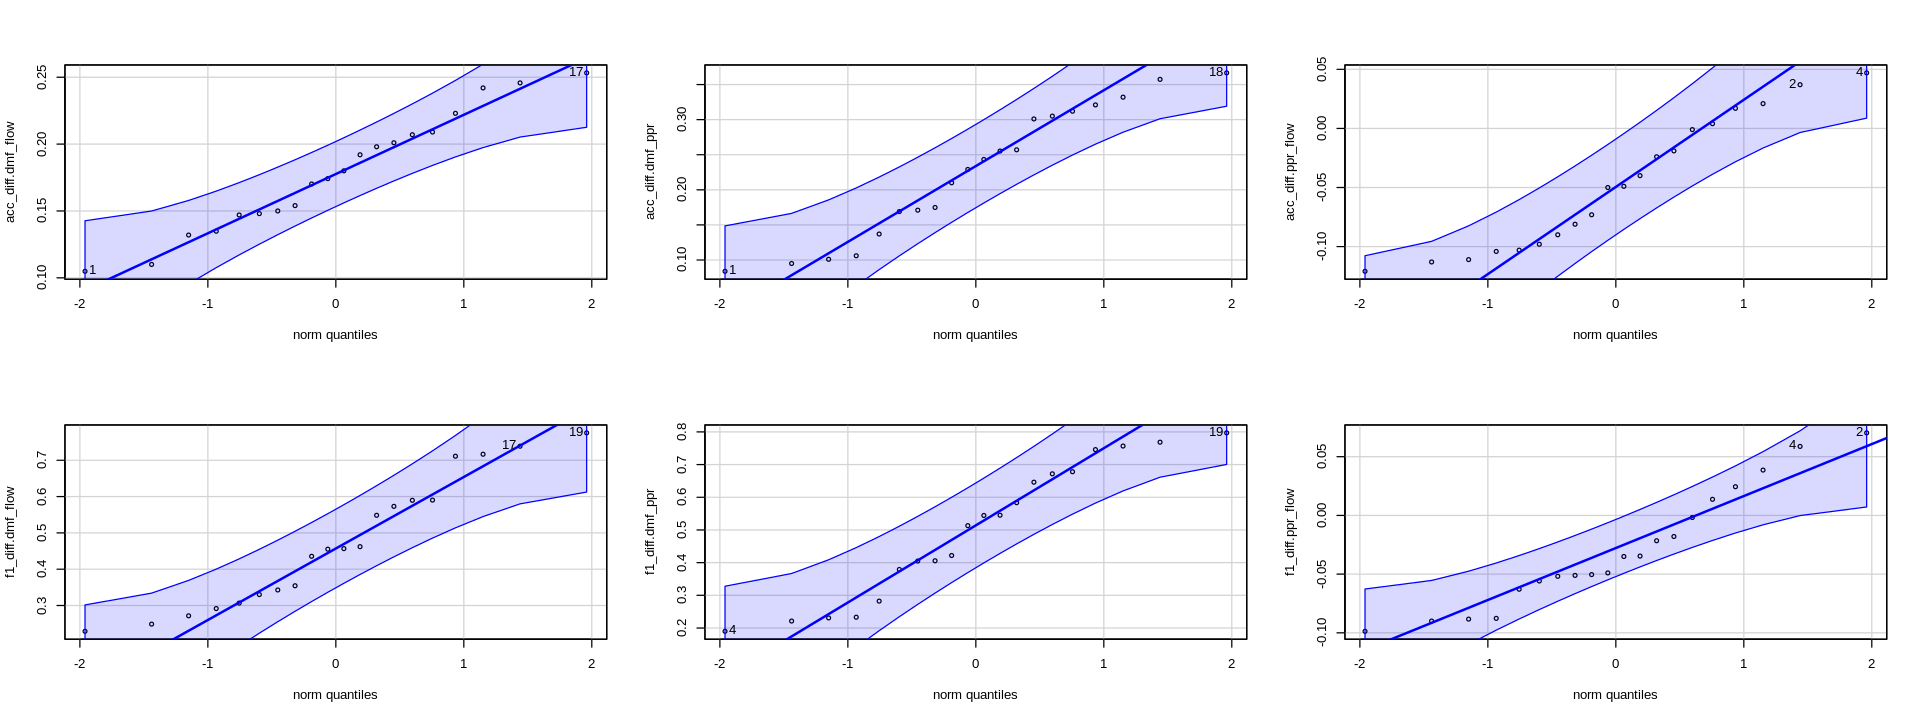

In [23]:
options(repr.plot.width=16, repr.plot.height=6)

# diff
acc_diff.dmf_flow <- plas_df$DMF_Acc - plas_df$PlasFlow_Acc
acc_diff.dmf_ppr <- plas_df$DMF_Acc - plas_df$PPR_Acc
acc_diff.ppr_flow <- plas_df$PPR_Acc - plas_df$PlasFlow_Acc
f1_diff.dmf_flow <- plas_df$DMF_F1 - plas_df$PlasFlow_F1
f1_diff.dmf_ppr <- plas_df$DMF_F1 - plas_df$PPR_F1
f1_diff.ppr_flow <- plas_df$PPR_F1 - plas_df$PlasFlow_F1

layout(matrix(c(1,2,3,4,5,6), 2, 3, byrow = TRUE), widths=c(1,1,1), heights=c(1,1,1))
a <- qqp(acc_diff.dmf_flow);
b <- qqp(acc_diff.dmf_ppr);
c <- qqp(acc_diff.ppr_flow);
d <- qqp(f1_diff.dmf_flow);
e <- qqp(f1_diff.dmf_ppr);
f <- qqp(f1_diff.ppr_flow);

In [24]:
# t-test Accuracy
anova_test(Accuracy ~ Predictor, data = plas_df_acc)
pairwise_t_test(Accuracy ~ Predictor, data = plas_df_acc, p.adjust.method = "bonferroni", paired=TRUE, pool.sd=FALSE, var.equal=FALSE)

# t-test F1 Scores
anova_test(F1Score ~ Predictor, data = plas_df_f1)
pairwise_t_test(F1Score ~ Predictor, data = plas_df_f1, p.adjust.method = "bonferroni", paired=TRUE, pool.sd=FALSE, var.equal=FALSE)

Coefficient covariances computed by hccm()



,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,Predictor,2,57,105.183,7.41e-20,*,0.787


,.y.,group1,group2,n1,n2,statistic,df,p,p.adj,p.adj.signif
,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,Accuracy,DMF_Acc,PlasFlow_Acc,20,20,18.235630,19,1.69e-13,5.07e-13,****
2,Accuracy,DMF_Acc,PPR_Acc,20,20,10.925494,19,1.24e-09,3.72e-09,****
3,Accuracy,PlasFlow_Acc,PPR_Acc,20,20,3.872954,19,1.00e-03,3.00e-03,**


Coefficient covariances computed by hccm()



,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,Predictor,2,57,52.917,1.02e-13,*,0.65


,.y.,group1,group2,n1,n2,statistic,df,p,p.adj,p.adj.signif
,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,F1Score,DMF_F1,PlasFlow_F1,20,20,12.007857,19,2.56e-10,7.68e-10,****
2,F1Score,DMF_F1,PPR_F1,20,20,11.029275,19,1.06e-09,3.18e-09,****
3,F1Score,PlasFlow_F1,PPR_F1,20,20,2.654883,19,1.60e-02,4.70e-02,*


In [25]:
# # compare accuracy
# my_comparisons <- list(c("DMF_Acc", "PlasFlow_Acc"), c("DMF_Acc", "PPR_Acc"), c("PlasFlow_Acc", "PPR_Acc"))
# plas_ttest_acc <- compare_means(Accuracy ~ Predictor,  data = plas_df_acc, comparisons=my_comparisons, method = "wilcox.test", p.adjust.method = "bonferroni", paired=TRUE)
# #plas_ttest_acc <- compare_means(Accuracy ~ Predictor,  data = plas_df_acc, comparisons=my_comparisons, method = "t.test", p.adjust.method = "bonferroni", paired=TRUE)
# plas_ttest_acc <- plas_ttest_acc %>% mutate(y.position=c(1, 1.05, 1.1))
# plas_ttest_acc

# # compare f1score
# my_comparisons <- list(c("DMF_F1", "PlasFlow_F1"), c("DMF_F1", "PPR_F1"), c("PlasFlow_F1", "PPR_F1"))
# plas_ttest_f1 <- compare_means(F1Score ~ Predictor,  data = plas_df_f1, comparisons=my_comparisons, method = "wilcox.test",  p.adjust.method = "bonferroni", paired=TRUE)
# #plas_ttest_f1 <- compare_means(F1Score ~ Predictor,  data = plas_df_f1, comparisons=my_comparisons, method = "t.test",  p.adjust.method = "bonferroni", paired=TRUE)
# plas_ttest_f1 <- plas_ttest_f1 %>% mutate(y.position=c(1, 1.05, 1.1))
# plas_ttest_f1

In [26]:
# check variance
aggregate(Accuracy ~ Predictor,  data = plas_df_acc, function(x) c(Var = var(x), Count = length(x)))
aggregate(F1Score ~ Predictor,  data = plas_df_f1, function(x) c(Var = var(x), Count = length(x)))

Predictor,Accuracy
<chr>,"<dbl[,2]>"
DMF_Acc,"0.0001188315, 20"
PlasFlow_Acc,"0.0011838145, 20"
PPR_Acc,"0.0068234722, 20"


Predictor,F1Score
<chr>,"<dbl[,2]>"
DMF_F1,"0.00116166, 20"
PlasFlow_F1,"0.03846498, 20"
PPR_F1,"0.04995295, 20"


Warning message in wilcox.test.default(c(0.968031968031968, 0.966, 0.957, 0.968, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.968031968031968, 0.966, 0.957, 0.968, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.863136863136863, 0.834, 0.847, 0.82, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.968031968031968, 0.966, 0.957, 0.968, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.968031968031968, 0.966, 0.957, 0.968, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.863136863136863, 0.834, 0.847, 0.82, :
“cannot compute exact p-value with ties”


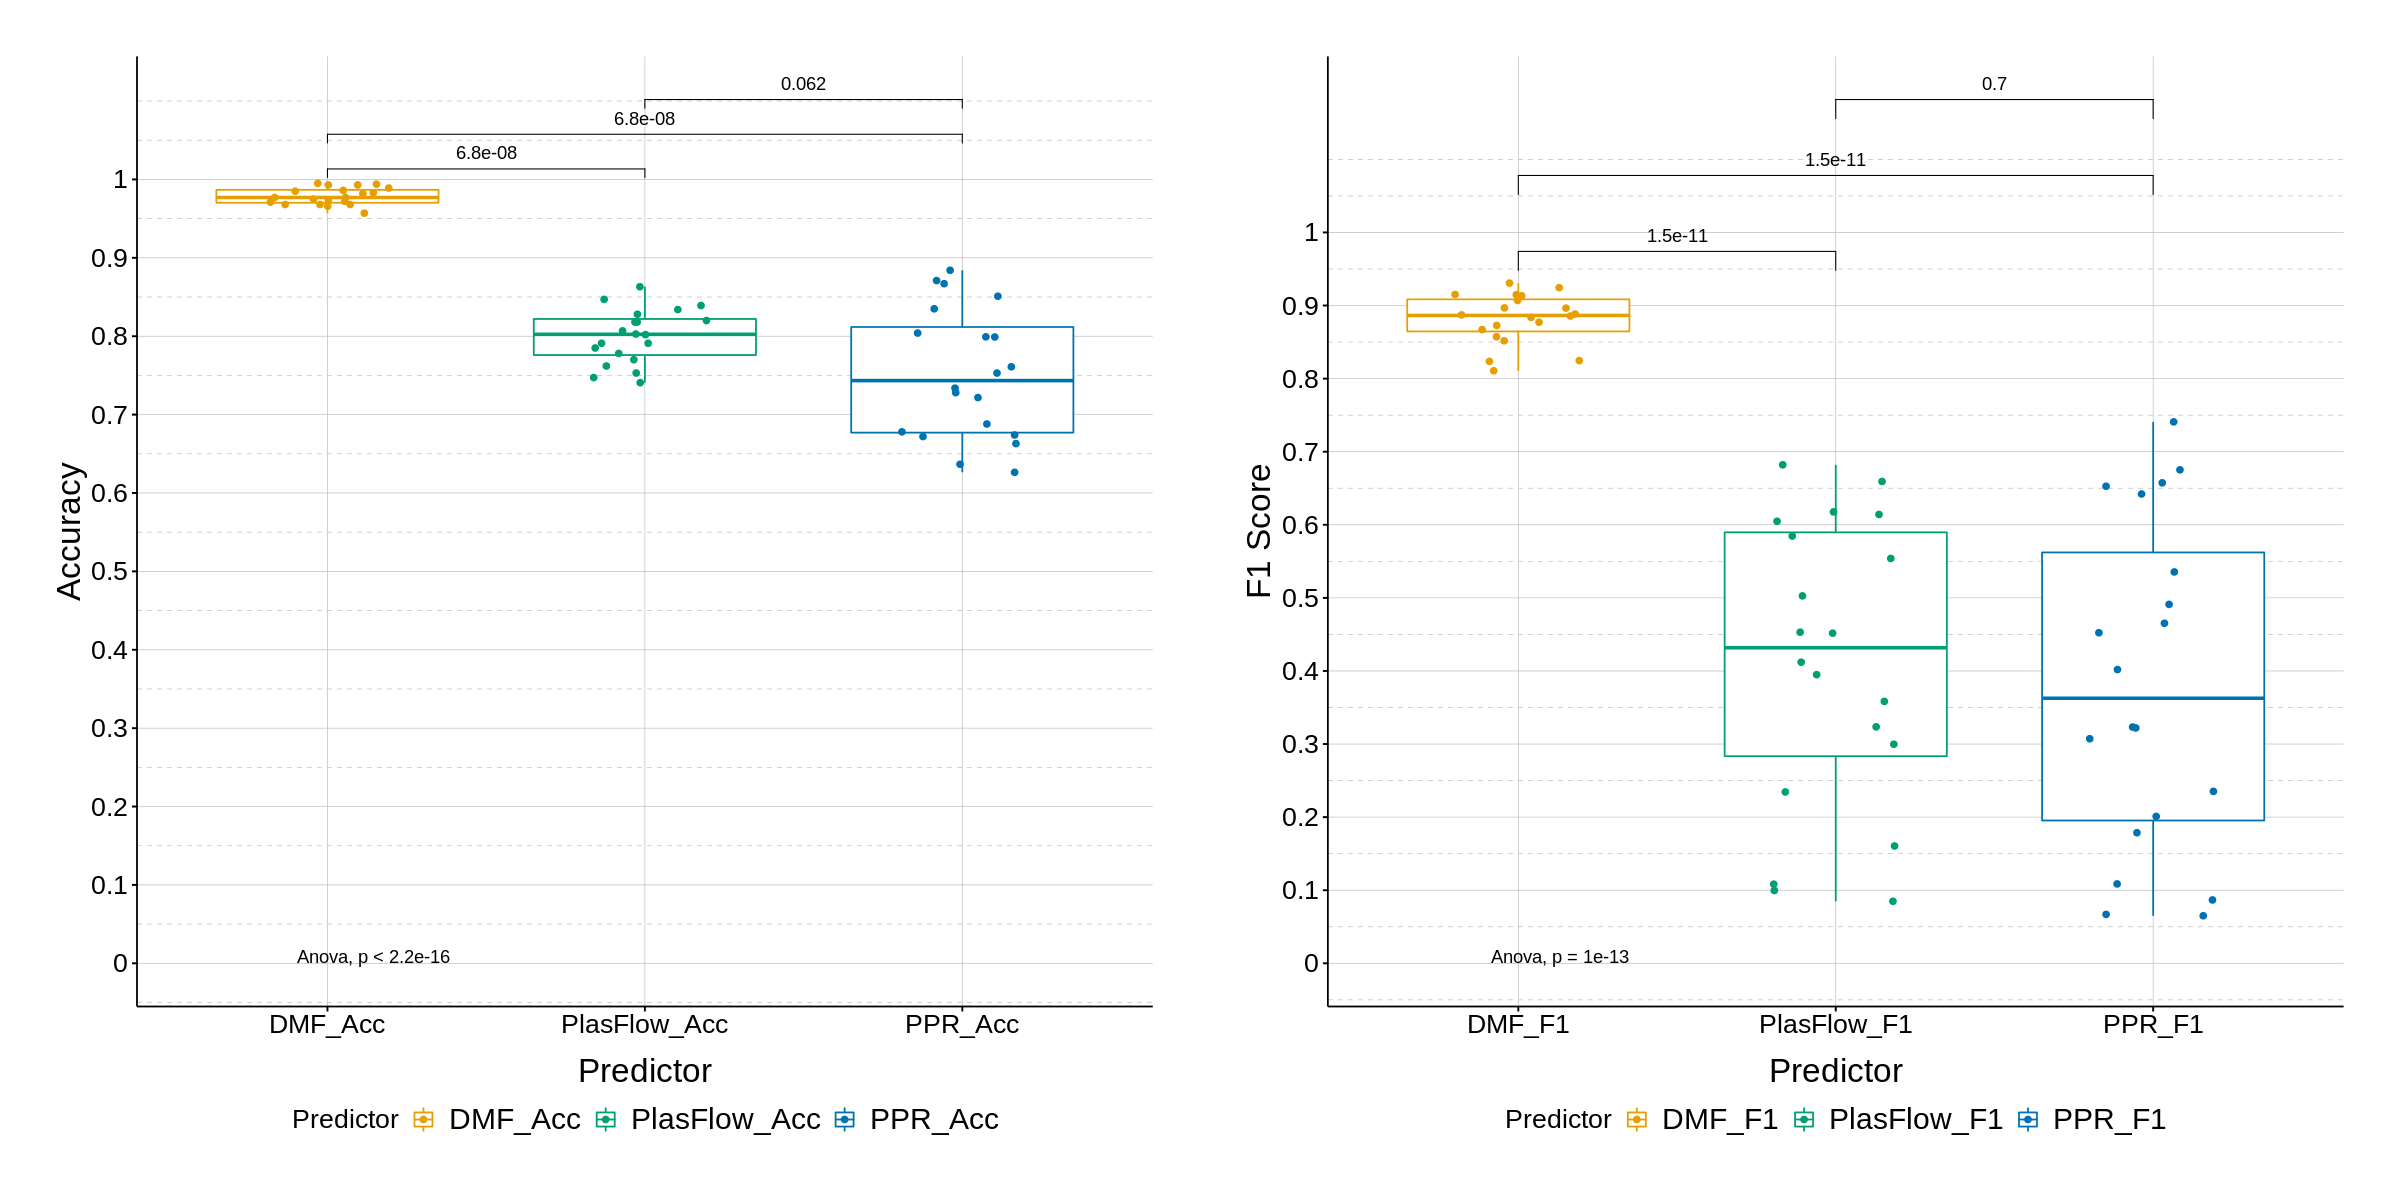

In [27]:
options(repr.plot.width=20, repr.plot.height=10)

#blind_colors <- c("orange2", "green", "blue", "vermillion", "purple", "black")
blind_colors <- c("#E69F00", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#000000")

my_comparisons <- list(c("DMF_Acc", "PlasFlow_Acc"), c("DMF_Acc", "PPR_Acc"), c("PlasFlow_Acc", "PPR_Acc"))
p_plas_acc_box <- ggboxplot(plas_df_acc, x = "Predictor", y = "Accuracy",
          color = "Predictor", palette = blind_colors, add = "jitter") + 
  stat_compare_means(comparisons = my_comparisons,  method = "wilcox.test", label = "p.adj") + # Add pairwise comparisons p-value
#   stat_pvalue_manual(plas_ttest_acc, label = "p.adj") +
  stat_compare_means(method = "anova", label.y = 0.) +    # Add global p-value
  labs(x="Predictor", y="Accuracy") + 
  scale_y_continuous(breaks = seq(0, 1, 0.1), labels = seq(0,1,0.1)) +  
  theme(panel.background = element_blank(), 
        axis.line = element_line(colour = "black"), 
        text = element_text(size = 16),
        axis.title.x = element_text(size=20, color="black", vjust=-1), 
        axis.title.y = element_text(size=20, color="black"), 
        axis.text.x = element_text(angle = 0, color="black"), 
        axis.text.y = element_text(angle = 0, color="black"), 
        panel.grid.minor.x = element_line(colour = "grey", size=0.2, linetype = 'dashed'), 
        panel.grid.major.x = element_line(colour = "grey", size=0.2),
        panel.grid.minor.y = element_line(colour = "grey", size = 0.2, linetype = 'dashed'),
        panel.grid.major.y = element_line(colour = "grey", size=0.2),
        legend.position = "bottom", 
        legend.text=element_text(size=18), 
        legend.key.size = unit(1,"line"), 
        plot.margin=unit(c(1,1,1,1),"cm")) 

my_comparisons <- list(c("DMF_F1", "PlasFlow_F1"), c("DMF_F1", "PPR_F1"), c("PlasFlow_F1", "PPR_F1"))
p_plas_f1_box <- ggboxplot(plas_df_f1, x = "Predictor", y = "F1Score",
         color = "Predictor", add="jitter",
         palette = blind_colors) +
  stat_compare_means(comparisons = my_comparisons,  method = "wilcox.test", label="p.adj") + # Add pairwise comparisons p-value
  # stat_pvalue_manual(plas_ttest_f1, label = "p.adj") +
  stat_compare_means(method = "anova", label.y = 0.) +    # Add global p-value
  labs(x="Predictor", y="F1 Score") + 
  scale_y_continuous(breaks = seq(0, 1, 0.1), labels = seq(0,1,0.1)) +  
  theme(panel.background = element_blank(), 
        axis.line = element_line(colour = "black"), 
        text = element_text(size = 16),
        axis.title.x = element_text(size=20, color="black", vjust=-1), 
        axis.title.y = element_text(size=20, color="black"), 
        axis.text.x = element_text(angle = 0, color="black"), 
        axis.text.y = element_text(angle = 0, color="black"), 
        panel.grid.minor.x = element_line(colour = "grey", size=0.2, linetype = 'dashed'), 
        panel.grid.major.x = element_line(colour = "grey", size=0.2),
        panel.grid.minor.y = element_line(colour = "grey", size = 0.2, linetype = 'dashed'),
        panel.grid.major.y = element_line(colour = "grey", size=0.2),
        legend.position = "bottom", 
        legend.text=element_text(size=18), 
        legend.key.size = unit(1,"line"), 
        plot.margin=unit(c(1,1,1,1),"cm"))

p_plas_box <- p_plas_acc_box + p_plas_f1_box
p_plas_box

ggsave(filename="DMF_PlasFlow_PPR_Plas_comparison_boxplot.svg", # useDingbats=FALSE, 
       plot = last_plot(), path=res_dir, 
       scale = 1, width = 400, height = 200, units = "mm",
       dpi = 300, limitsize = FALSE)

### - summary of Accuracy and F1-Score for Plasmid contig classification

In [28]:
# summary of accuracy
plas_df_acc %>% 
  group_by(Predictor) %>% 
  summarise(mean=mean(Accuracy), var=var(Accuracy), sd=sd(Accuracy))

# summary of f1 score
plas_df_f1 %>% 
  group_by(Predictor) %>% 
  summarise(mean=mean(F1Score), var=var(F1Score), sd=sd(F1Score))

Predictor,mean,var,sd
<chr>,<dbl>,<dbl>,<dbl>
DMF_Acc,0.9786506,0.0001188315,0.01090099
PlasFlow_Acc,0.7998450,0.0011838145,0.03440661
PPR_Acc,0.7522891,0.0068234722,0.08260431


Predictor,mean,var,sd
<chr>,<dbl>,<dbl>,<dbl>
DMF_F1,0.8813966,0.00116166,0.03408314
PlasFlow_F1,0.4100015,0.03846498,0.19612491
PPR_F1,0.3804520,0.04995295,0.22350157


# Comparison of Prokaryotic Virus Classification

In [29]:
# DeepMicrobeFinder Prok Virus
df_dmf_prok_virus <- df_dmf %>% filter(category == "prokaryote_virus")
df_dmf_prok_virus <- df_dmf_prok_virus[match(dataset_order_names, df_dmf_prok_virus$filename),]
rownames(df_dmf_prok_virus) <- seq(0, 19)
head(df_dmf_prok_virus, 2)

df_dvf_prok <- df_dvf[match(dataset_order_names, df_dvf$filename),]
rownames(df_dvf_prok) <- seq(0, 19)
head(df_dvf_prok, 2)

# VIBRANT Virus
df_vibrant_virus <- df_vibrant[match(dataset_order_names, df_vibrant$filename),]
rownames(df_vibrant_virus) <- seq(0, 19)
head(df_vibrant_virus, 2)

# PPR Virus
df_ppr_virus <- df_ppr_vir[match(dataset_order_names, df_ppr_vir$filename),]
rownames(df_ppr_virus) <- seq(0, 19)
head(df_ppr_virus, 2)

# merge DeepMicrobeFinder, PlasFlow and PPR-Meta
# prok_vir_df <- cbind(df_dmf_prok_virus[, c("f1_score", "accuracy")], df_virsorter_virus[, c("f1_score", "accuracy")], df_vibrant_virus[, c("f1_score", "accuracy")], df_ppr_virus[, c("f1_score", "accuracy")])
prok_vir_df <- cbind(df_dmf_prok_virus[, c("f1_score", "accuracy")], df_dvf_prok[, c("f1_score", "accuracy")], df_vibrant_virus[, c("f1_score", "accuracy")], df_ppr_virus[, c("f1_score", "accuracy")])
colnames(prok_vir_df) <- c("DMF_F1", "DMF_Acc", "DVF_F1", "DVF_Acc", "VIBRANT_F1", "VIBRANT_Acc", "PPR_F1", "PPR_Acc")
ds_order <- paste("DS", rownames(prok_vir_df), sep = "_")
prok_vir_df$Dataset_No = factor(ds_order, levels=ds_order) 
head(prok_vir_df, 2)

,filename,category,f1_score,accuracy
,<chr>,<chr>,<dbl>,<dbl>
0,643_129_129_83_17,prokaryote_virus,0.9612403,0.99001
1,600_150_150_80_20,prokaryote_virus,0.9568106,0.98700


,filename,f1_score,accuracy
,<chr>,<dbl>,<dbl>
0,643_129_129_83_17,0.5693069,0.8261738
1,600_150_150_80_20,0.6527778,0.8500000


,filename,f1_score,accuracy
,<chr>,<dbl>,<dbl>
0,643_129_129_83_17,0.8865979,0.967033
1,600_150_150_80_20,0.8739003,0.957000


,filename,f1_score,accuracy
,<chr>,<dbl>,<dbl>
0,643_129_129_83_17,0.7619048,0.9200799
1,600_150_150_80_20,0.7967914,0.9240000


,DMF_F1,DMF_Acc,DVF_F1,DVF_Acc,VIBRANT_F1,VIBRANT_Acc,PPR_F1,PPR_Acc,Dataset_No
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0,0.9612403,0.99001,0.5693069,0.8261738,0.8865979,0.967033,0.7619048,0.9200799,DS_0
1,0.9568106,0.98700,0.6527778,0.8500000,0.8739003,0.957000,0.7967914,0.9240000,DS_1


### - Plot accuracy and F1 score for DMF, DVF, VIBRANT and PPR

,Dataset_No,Predictor,F1Score
,<fct>,<chr>,<dbl>
1,DS_0,DMF_F1,0.9612403
2,DS_1,DMF_F1,0.9568106


,Dataset_No,Predictor,Accuracy
,<fct>,<chr>,<dbl>
1,DS_0,DMF_Acc,0.99001
2,DS_1,DMF_Acc,0.98700


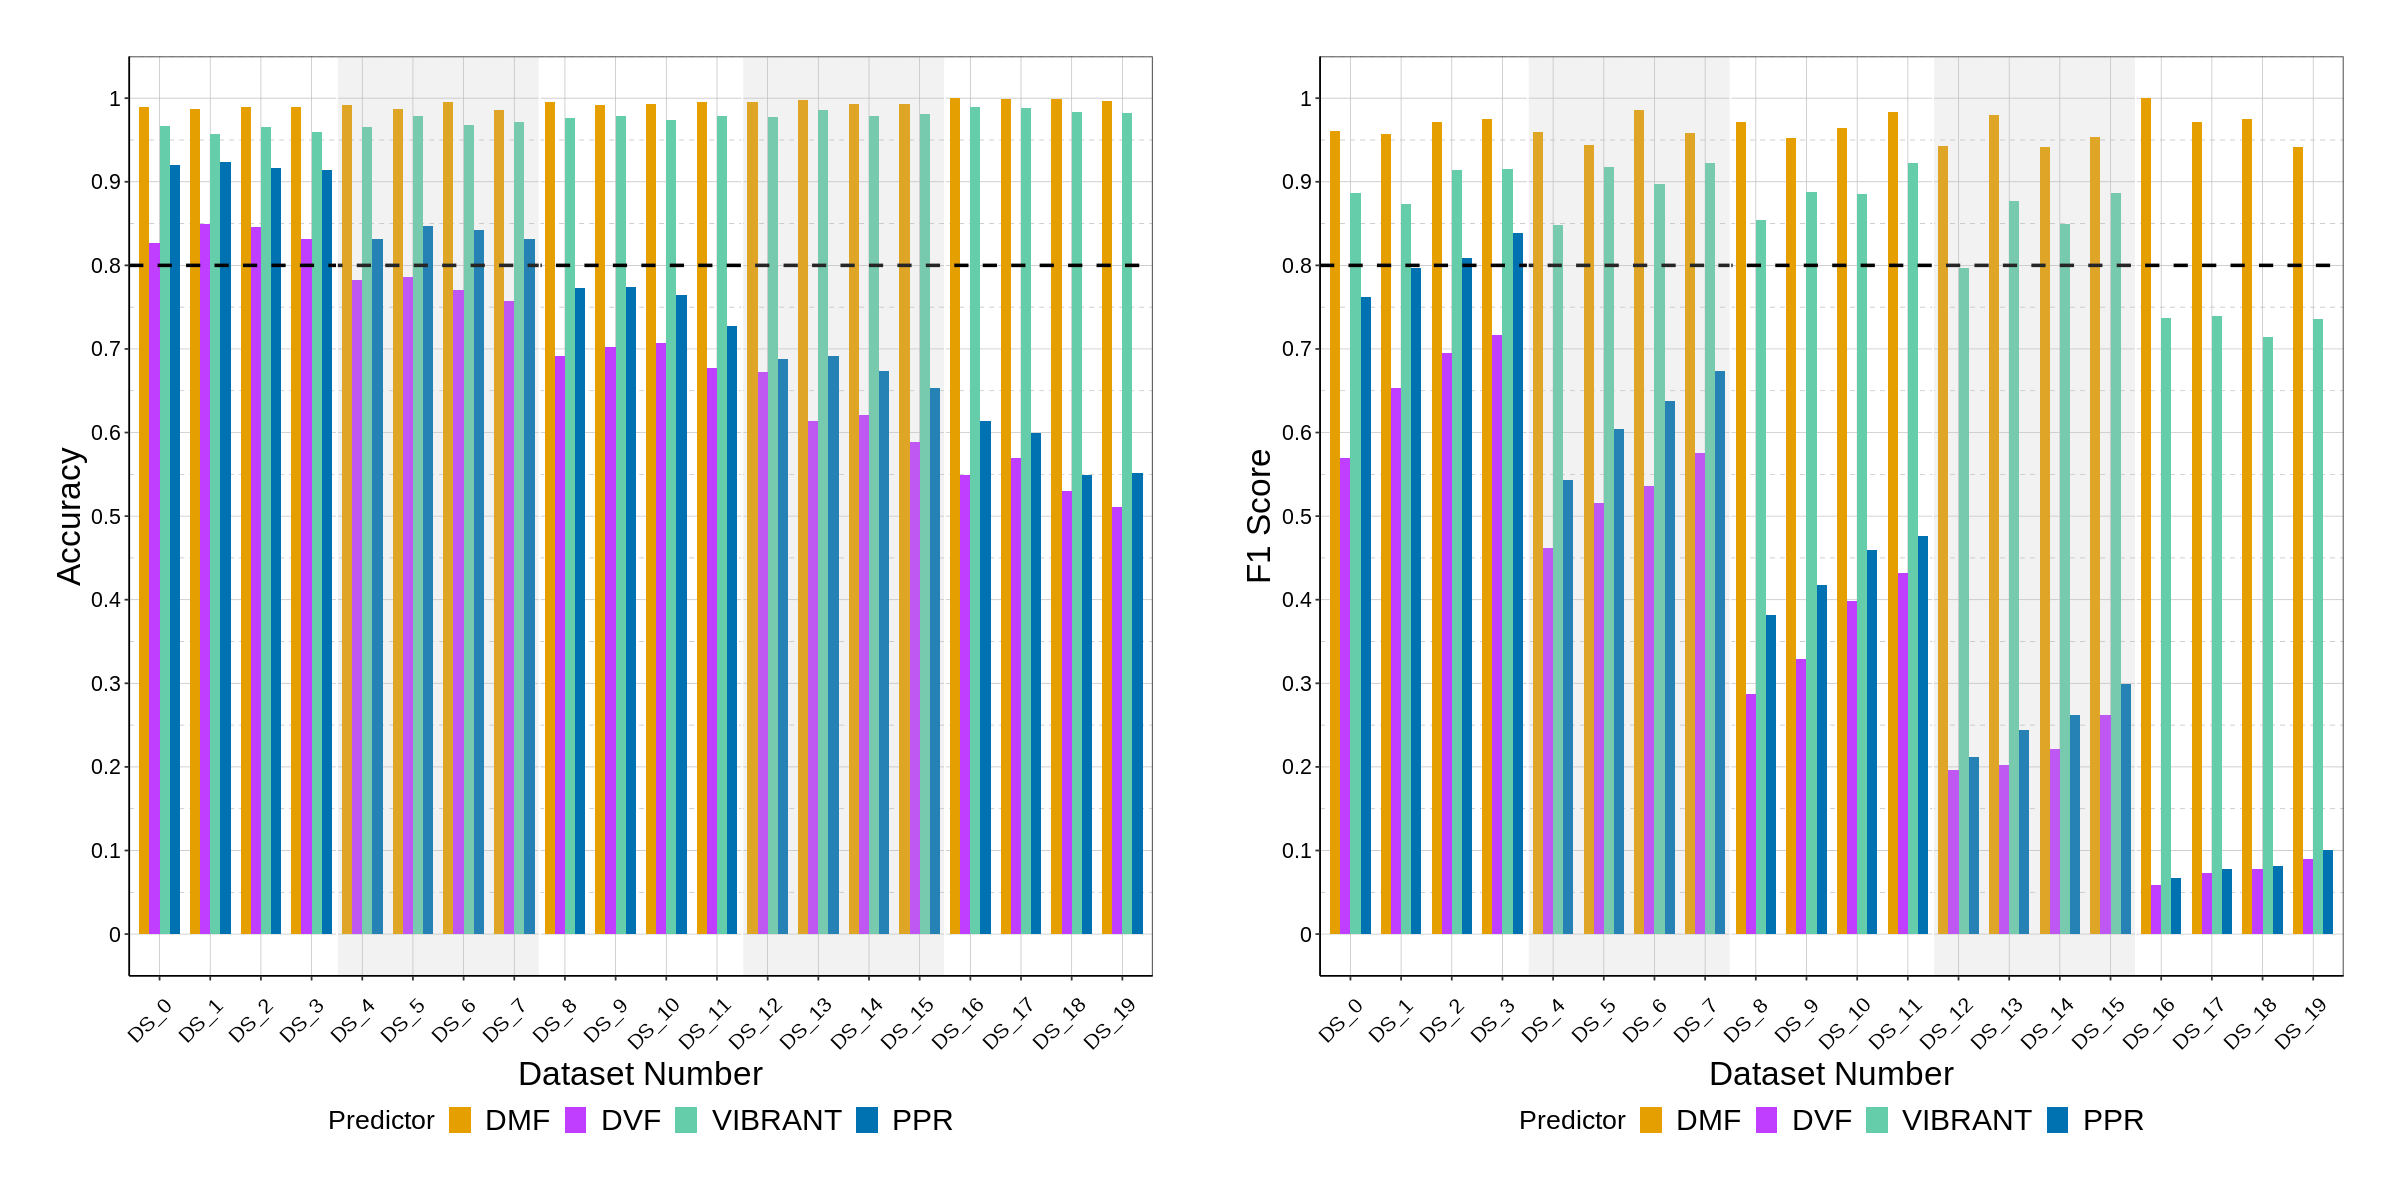

In [30]:
options(repr.plot.width=20, repr.plot.height=10)

# Virus F1 Score
prok_vir_df_f1 <- prok_vir_df %>% 
  select(Dataset_No, DMF_F1, DVF_F1, VIBRANT_F1, PPR_F1) %>% 
  tidyr::gather(-Dataset_No, key = "Predictor", value = "F1Score")
head(prok_vir_df_f1, 2)
prok_vir_df_f1$Predictor <- factor(prok_vir_df_f1$Predictor, levels = c("DMF_F1", "DVF_F1", "VIBRANT_F1", "PPR_F1"))

#blind_colors <- c("orange2", "darkorchid1", "aquamarine3","blue", "vermillion", "purple", "black")
blind_colors <- c("#E69F00", "darkorchid1", "aquamarine3","#0072B2", "#D55E00", "#CC79A7", "#000000")

p_vir_f1 <- ggplot(data = prok_vir_df_f1, aes(x=Dataset_No, y=F1Score, fill=Predictor)) + 
  geom_bar(width=0.8, position = "dodge", stat="identity") +
  # scale_fill_manual(name = "Predictor", values=blind_colors, labels = c("DeepMicrobeFinder", "DeepVirFinder", "VIBRANT", "PPR-Meta")) + 
  scale_fill_manual(name = "Predictor", values=blind_colors, labels = c("DMF", "DVF", "VIBRANT", "PPR")) + 
  scale_y_continuous(breaks = seq(0, 1, 0.1), labels = seq(0,1,0.1)) +  
  geom_hline(yintercept=0.8, linetype="dashed", size=1, color = "black") +
  labs(x="Dataset Number", y="F1 Score") + 
  coord_cartesian(ylim = c(0, 1)) +
  theme_bw() + 
  geom_rect(data=rects_2, mapping=aes(xmin=xmin, xmax=xmax, ymin = -Inf, ymax = Inf), fill="grey", color="white", alpha = 0.2, inherit.aes = FALSE) +
  theme(panel.background = element_blank(), 
        axis.line = element_line(colour = "black"), 
        text = element_text(size = 16),
        axis.title.x = element_text(size=20, color="black", vjust=-1), 
        axis.title.y = element_text(size=20, color="black"), 
        axis.text.x = element_text(angle = 45, hjust = 0.8, vjust=0.6, color="black"), 
        axis.text.y = element_text(angle = 0, color="black"), 
        panel.grid.minor.x = element_line(colour = "grey", size=0.2, linetype = 'dashed'), 
        panel.grid.major.x = element_line(colour = "grey", size=0.2),
        panel.grid.minor.y = element_line(colour = "grey", size = 0.2, linetype = 'dashed'),
        panel.grid.major.y = element_line(colour = "grey", size=0.2),
        legend.position = "bottom", 
        legend.text=element_text(size=18), 
        legend.key.size = unit(1,"line"), 
        plot.margin=unit(c(1,1,1,1),"cm"))

# Virus Accuracy
vir_df_acc <- prok_vir_df %>% 
  # select(Dataset_No, DMF_Acc, VirSorter_Acc, VIBRANT_Acc, PPR_Acc) %>% 
  select(Dataset_No, DMF_Acc, DVF_Acc, VIBRANT_Acc, PPR_Acc) %>% 
  tidyr::gather(-Dataset_No, key = "Predictor", value = "Accuracy")
head(vir_df_acc, 2)
vir_df_acc$Predictor <- factor(vir_df_acc$Predictor, levels = c("DMF_Acc", "DVF_Acc", "VIBRANT_Acc", "PPR_Acc"))

p_vir_acc <- ggplot(data = vir_df_acc, aes(x=Dataset_No, y=Accuracy, fill=Predictor)) + 
  geom_bar(width=0.8, position = "dodge", stat="identity") +
  # scale_fill_manual(name = "Predictor", values=blind_colors, labels = c("DeepMicrobeFinder", "DeepVirFinder", "VIBRANT", "PPR-Meta")) + 
  scale_fill_manual(name = "Predictor", values=blind_colors, labels = c("DMF", "DVF", "VIBRANT", "PPR")) + 
  scale_y_continuous(breaks = seq(0, 1, 0.1), labels = seq(0,1,0.1)) +  
  geom_hline(yintercept=0.8, linetype="dashed", size=1, color = "black") +
  labs(x="Dataset Number", y="Accuracy") + 
  coord_cartesian(ylim = c(0, 1)) +
  theme_bw() + 
  geom_rect(data=rects_2, mapping=aes(xmin=xmin, xmax=xmax, ymin = -Inf, ymax = Inf), fill="grey", color="white", alpha = 0.2, inherit.aes = FALSE) +
  theme(panel.background = element_blank(), 
        axis.line = element_line(colour = "black"), 
        text = element_text(size = 16),
        axis.title.x = element_text(size=20, color="black", vjust=-1), 
        axis.title.y = element_text(size=20, color="black"), 
        axis.text.x = element_text(angle = 45, hjust = 0.8, vjust=0.6, color="black"), 
        axis.text.y = element_text(angle = 0, color="black"), 
        panel.grid.minor.x = element_line(colour = "grey", size=0.2, linetype = 'dashed'), 
        panel.grid.major.x = element_line(colour = "grey", size=0.2),
        panel.grid.minor.y = element_line(colour = "grey", size = 0.2, linetype = 'dashed'),
        panel.grid.major.y = element_line(colour = "grey", size=0.2),
        legend.position = "bottom", 
        legend.text=element_text(size=18), 
        legend.key.size = unit(1,"line"), 
        plot.margin=unit(c(1,1,1,1),"cm"))

p_vir_bar <- p_vir_acc + p_vir_f1
p_vir_bar

ggsave(filename="DMF_DVF_VIBRANT_PPR_Prok_Vir_comparison_barplot.svg", # useDingbats=FALSE, 
       plot = last_plot(), path=res_dir, 
       scale = 1, width = 400, height = 200, units = "mm",
       dpi = 300, limitsize = FALSE)

### - pairwise t-test on Accuracy and F1Score

In [144]:
# # t-test Accuracy
# anova_test(Accuracy ~ Predictor, data = vir_df_acc)
# pairwise_t_test(Accuracy ~ Predictor, data = vir_df_acc, p.adjust.method = "bonferroni", pool.sd=FALSE, paired=TRUE)

# # t-test F1 Scores
# anova_test(F1Score ~ Predictor, data = prok_vir_df_f1)
# pairwise_t_test(F1Score ~ Predictor, data = prok_vir_df_f1, p.adjust.method = "bonferroni", pool.sd=FALSE, paired=TRUE)

### - compare means of accuracy and F1 score by t-test

In [145]:
# # compare accuracy
# my_comparisons <- list(c("DMF_Acc", "VIBRANT_Acc"), c("DMF_Acc", "PPR_Acc"), c("VIBRANT_Acc", "PPR_Acc"))
# #vir_ttest_acc <- compare_means(Accuracy ~ Predictor,  data = vir_df_acc, comparisons=my_comparisons, method = "t.test", p.adjust.method = "bonferroni")
# vir_ttest_acc <- compare_means(Accuracy ~ Predictor,  data = vir_df_acc, comparisons=my_comparisons, method = "wilcox.test", p.adjust.method = "bonferroni", paired=TRUE)
# vir_ttest_acc <- vir_ttest_acc %>% mutate(y.position=c(1, 1.025, 1.05))
# vir_ttest_acc

# # compare f1score
# my_comparisons <- list(c("DMF_F1", "VIBRANT_F1"), c("DMF_F1", "PPR_F1"), c("VIBRANT_F1", "PPR_F1"))
# # vir_ttest_f1 <- compare_means(F1Score ~ Predictor,  data = prok_vir_df_f1, comparisons=my_comparisons, method = "t.test",  p.adjust.method = "bonferroni")
# vir_ttest_f1 <- compare_means(F1Score ~ Predictor,  data = prok_vir_df_f1, comparisons=my_comparisons, method = "wilcox.test",  p.adjust.method = "bonferroni", paired=TRUE)
# vir_ttest_f1 <- vir_ttest_f1 %>% mutate(y.position=c(1, 1.025, 1.05))
# vir_ttest_f1

Warning message in wilcox.test.default(c(0.99000999000999, 0.987, 0.99, 0.989, 0.992, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.99000999000999, 0.987, 0.99, 0.989, 0.992, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.99000999000999, 0.987, 0.99, 0.989, 0.992, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.99000999000999, 0.987, 0.99, 0.989, 0.992, :
“cannot compute exact p-value with ties”


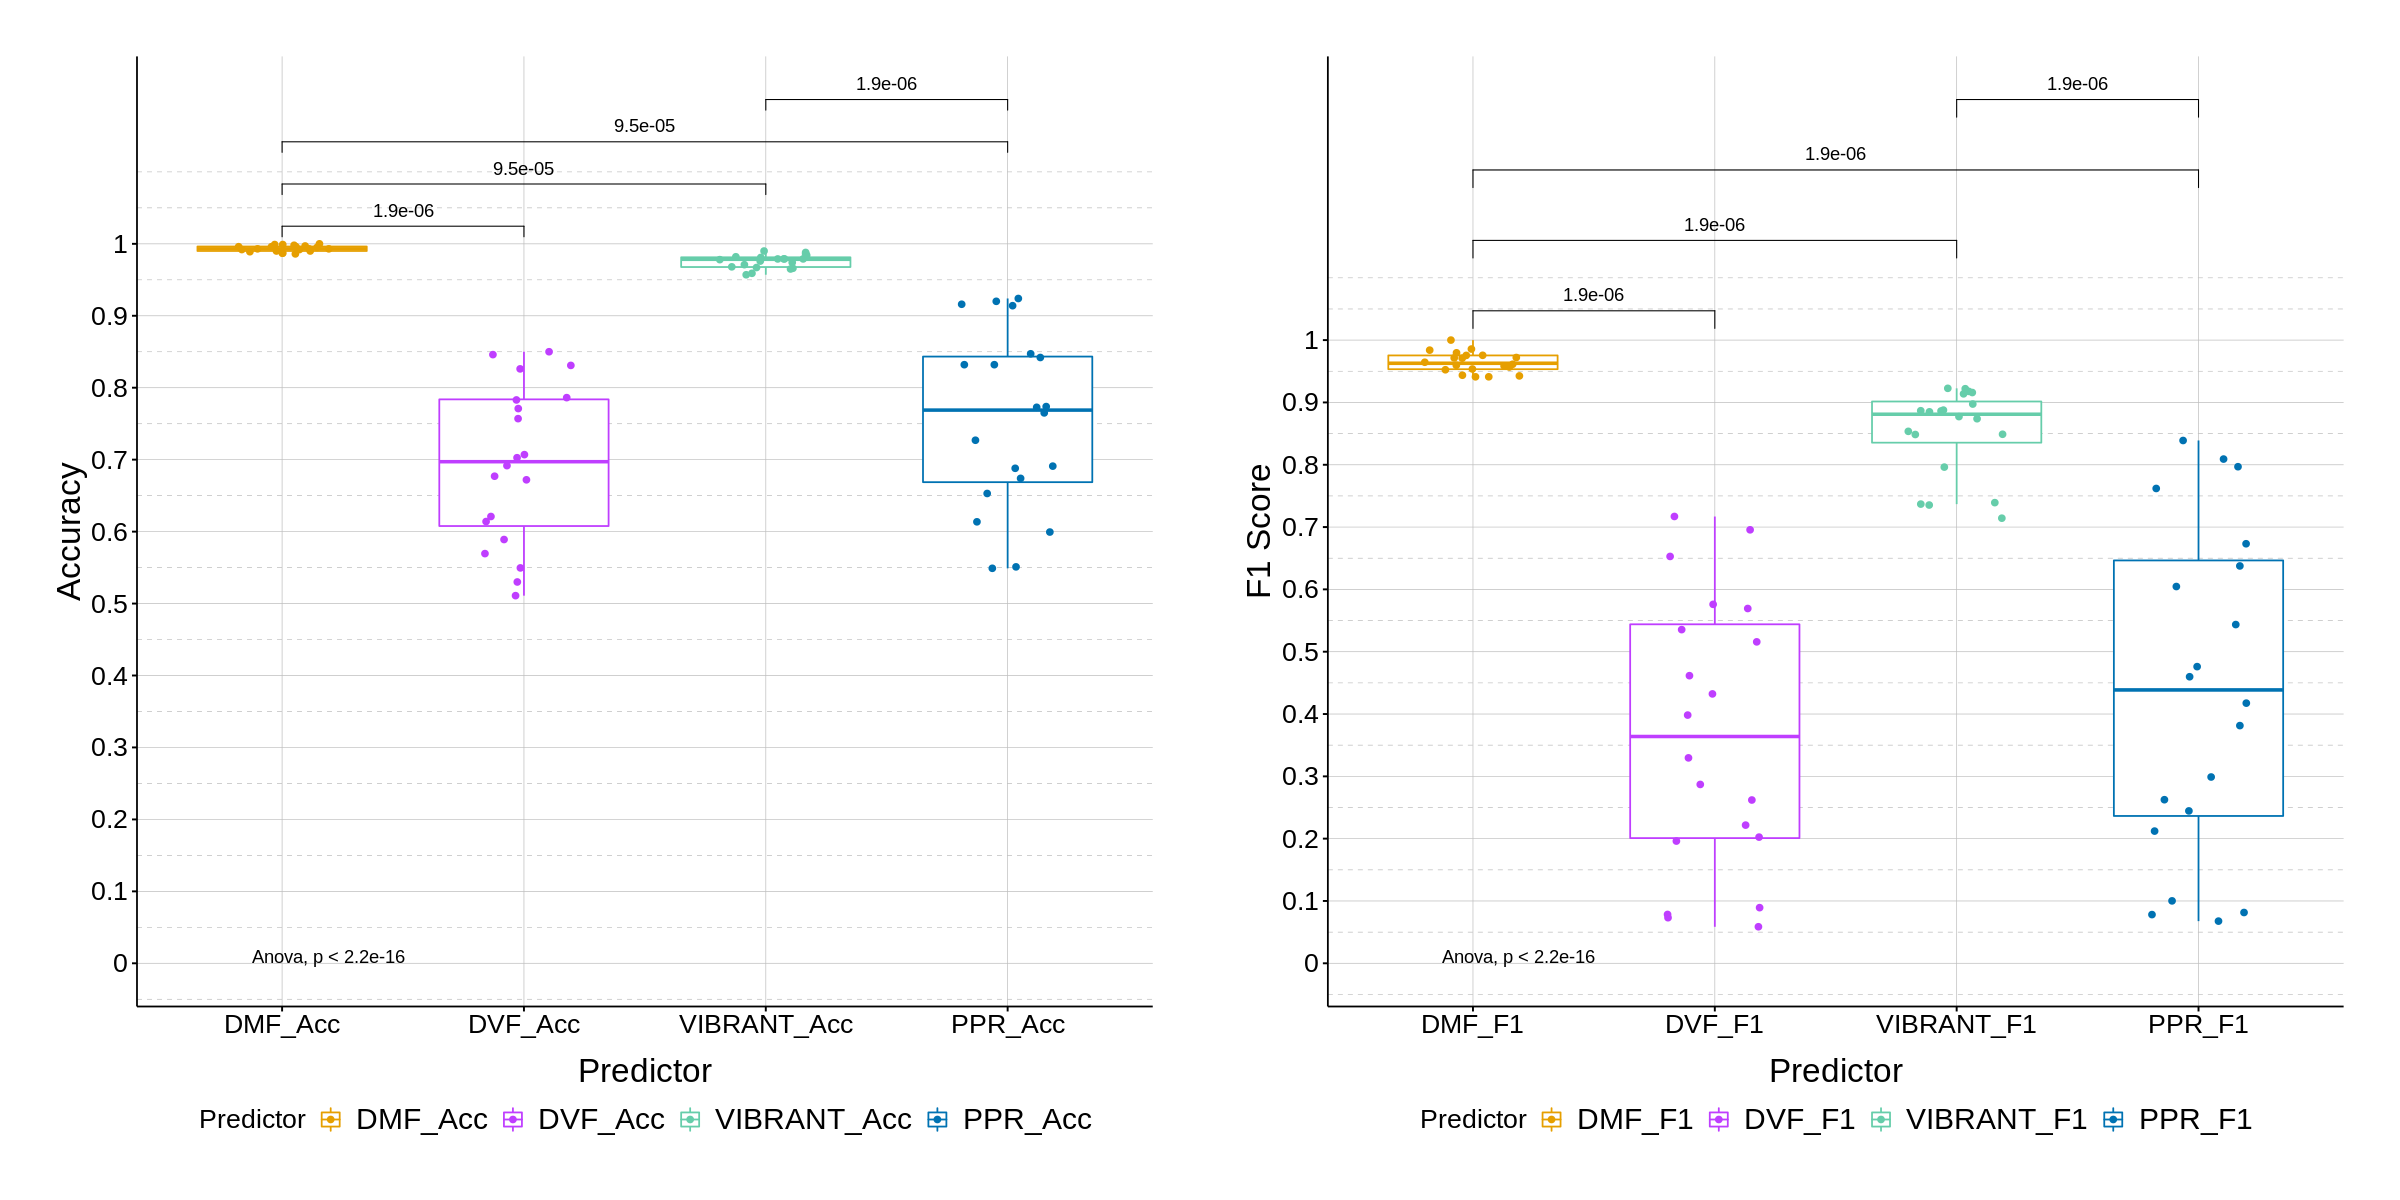

In [146]:
options(repr.plot.width=20, repr.plot.height=10)

#blind_colors <- c("orange2", "darkorchid1", "aquamarine3","blue", "vermillion", "purple", "black")
blind_colors <- c("#E69F00", "darkorchid1", "aquamarine3","#0072B2", "#D55E00", "#CC79A7", "#000000")

my_comparisons <- list(c("DMF_Acc", "DVF_Acc"), c("DMF_Acc", "VIBRANT_Acc"), c("DMF_Acc", "PPR_Acc"), c("VIBRANT_Acc", "PPR_Acc"))
p_vir_acc_box <- ggboxplot(vir_df_acc, x = "Predictor", y = "Accuracy",
          color = "Predictor", palette = blind_colors, add = "jitter") + 
  stat_compare_means(comparisons = my_comparisons,  method = "wilcox.test", paired = TRUE) + # Add pairwise comparisons p-value
#   stat_pvalue_manual(vir_ttest_acc, label = "p.adj") +
  stat_compare_means(method = "anova", label.y = 0.) +    # Add global p-value
  labs(x="Predictor", y="Accuracy") + 
  scale_y_continuous(breaks = seq(0, 1, 0.1), labels = seq(0,1,0.1)) +  
  theme(panel.background = element_blank(), 
        axis.line = element_line(colour = "black"), 
        text = element_text(size = 16),
        axis.title.x = element_text(size=20, color="black", vjust=-1), 
        axis.title.y = element_text(size=20, color="black"), 
        axis.text.x = element_text(angle = 0, color="black"), 
        axis.text.y = element_text(angle = 0, color="black"), 
        panel.grid.minor.x = element_line(colour = "grey", size=0.2, linetype = 'dashed'), 
        panel.grid.major.x = element_line(colour = "grey", size=0.2),
        panel.grid.minor.y = element_line(colour = "grey", size = 0.2, linetype = 'dashed'),
        panel.grid.major.y = element_line(colour = "grey", size=0.2),
        legend.position = "bottom", 
        legend.text=element_text(size=18), 
        legend.key.size = unit(1,"line"), 
        plot.margin=unit(c(1,1,1,1),"cm"))


my_comparisons <- list(c("DMF_F1", "DVF_F1"), c("DMF_F1", "VIBRANT_F1"), c("DMF_F1", "PPR_F1"), c("VIBRANT_F1", "PPR_F1"))
p_vir_f1_box <- ggboxplot(prok_vir_df_f1, x = "Predictor", y = "F1Score",
         color = "Predictor", add="jitter",
         palette = blind_colors) +
  stat_compare_means(comparisons = my_comparisons,  method = "wilcox.test", paired = TRUE) + # Add pairwise comparisons p-value
#   stat_pvalue_manual(vir_ttest_f1, label = "p.adj") +
  stat_compare_means(method = "anova", label.y = 0.) +    # Add global p-value
  labs(x="Predictor", y="F1 Score") + 
  scale_y_continuous(breaks = seq(0, 1, 0.1), labels = seq(0,1,0.1)) +  
  theme(panel.background = element_blank(), 
        axis.line = element_line(colour = "black"), 
        text = element_text(size = 16),
        axis.title.x = element_text(size=20, color="black", vjust=-1), 
        axis.title.y = element_text(size=20, color="black"), 
        axis.text.x = element_text(angle = 0, color="black"), 
        axis.text.y = element_text(angle = 0, color="black"), 
        panel.grid.minor.x = element_line(colour = "grey", size=0.2, linetype = 'dashed'), 
        panel.grid.major.x = element_line(colour = "grey", size=0.2),
        panel.grid.minor.y = element_line(colour = "grey", size = 0.2, linetype = 'dashed'),
        panel.grid.major.y = element_line(colour = "grey", size=0.2),
        legend.position = "bottom", 
        legend.text=element_text(size=18), 
        legend.key.size = unit(1,"line"), 
        plot.margin=unit(c(1,1,1,1),"cm"))

p_vir_box <- p_vir_acc_box + p_vir_f1_box
p_vir_box

ggsave(filename="DMF_VIBRANT_PPR_Prok_Vir_comparison_boxplot.svg", # useDingbats=FALSE, 
       plot = last_plot(), path=res_dir, 
       scale = 1, width = 400, height = 200, units = "mm",
       dpi = 300, limitsize = FALSE)

### - summary of Accuracy and F1-Score for Prokaryotic Viral contig classification

In [147]:
# summary of accuracy
vir_df_acc %>% 
  group_by(Predictor) %>% 
  summarise(mean=mean(Accuracy), var=var(Accuracy), sd=sd(Accuracy))

# summary of f1 score
prok_vir_df_f1 %>% 
  group_by(Predictor) %>% 
  summarise(mean=mean(F1Score), var=var(F1Score), sd=sd(F1Score))

Predictor,mean,var,sd
<fct>,<dbl>,<dbl>,<dbl>
DMF_Acc,0.9934006,1.824100e-05,0.004270948
DVF_Acc,0.6942381,1.213398e-02,0.110154368
VIBRANT_Acc,0.9754005,8.643314e-05,0.009296942
PPR_Acc,0.7542397,1.527777e-02,0.123603265


Predictor,mean,var,sd
<fct>,<dbl>,<dbl>,<dbl>
DMF_F1,0.9644954,0.0002681424,0.01637505
DVF_F1,0.3676351,0.0473381678,0.21757336
VIBRANT_F1,0.8529344,0.0048251402,0.06946323
PPR_F1,0.4372962,0.0693772935,0.26339570


# Comparison of Prok and Euk Virus Classification

In [148]:
# DeepMicrobeFinder Virus
df_dmf_prok_virus <- df_dmf %>% filter(category == "virus")
df_dmf_prok_virus <- df_dmf_prok_virus[match(dataset_order_names, df_dmf_prok_virus$filename),]
rownames(df_dmf_prok_virus) <- seq(0, 19)
# head(df_dmf_prok_virus, 2)

# VirSorter Virus
df_virsorter_virus <- df_virsorter[match(dataset_order_names, df_virsorter$filename),]
rownames(df_virsorter_virus) <- seq(0, 19)
# head(df_virsorter_virus, 2)

# merge DeepMicrobeFinder, PlasFlow and PPR-Meta
vir_df <- cbind(df_dmf_prok_virus[, c("f1_score", "accuracy")], df_virsorter_virus[, c("f1_score", "accuracy")])
colnames(vir_df) <- c("DMF_F1", "DMF_Acc", "VirSorter_F1", "VirSorter_Acc")
ds_order <- paste("DS", rownames(vir_df), sep = "_")
vir_df$Dataset_No = factor(ds_order, levels=ds_order) 
# head(vir_df, 2)

### - Plot accuracy and F1 score for DMF and VirSorter

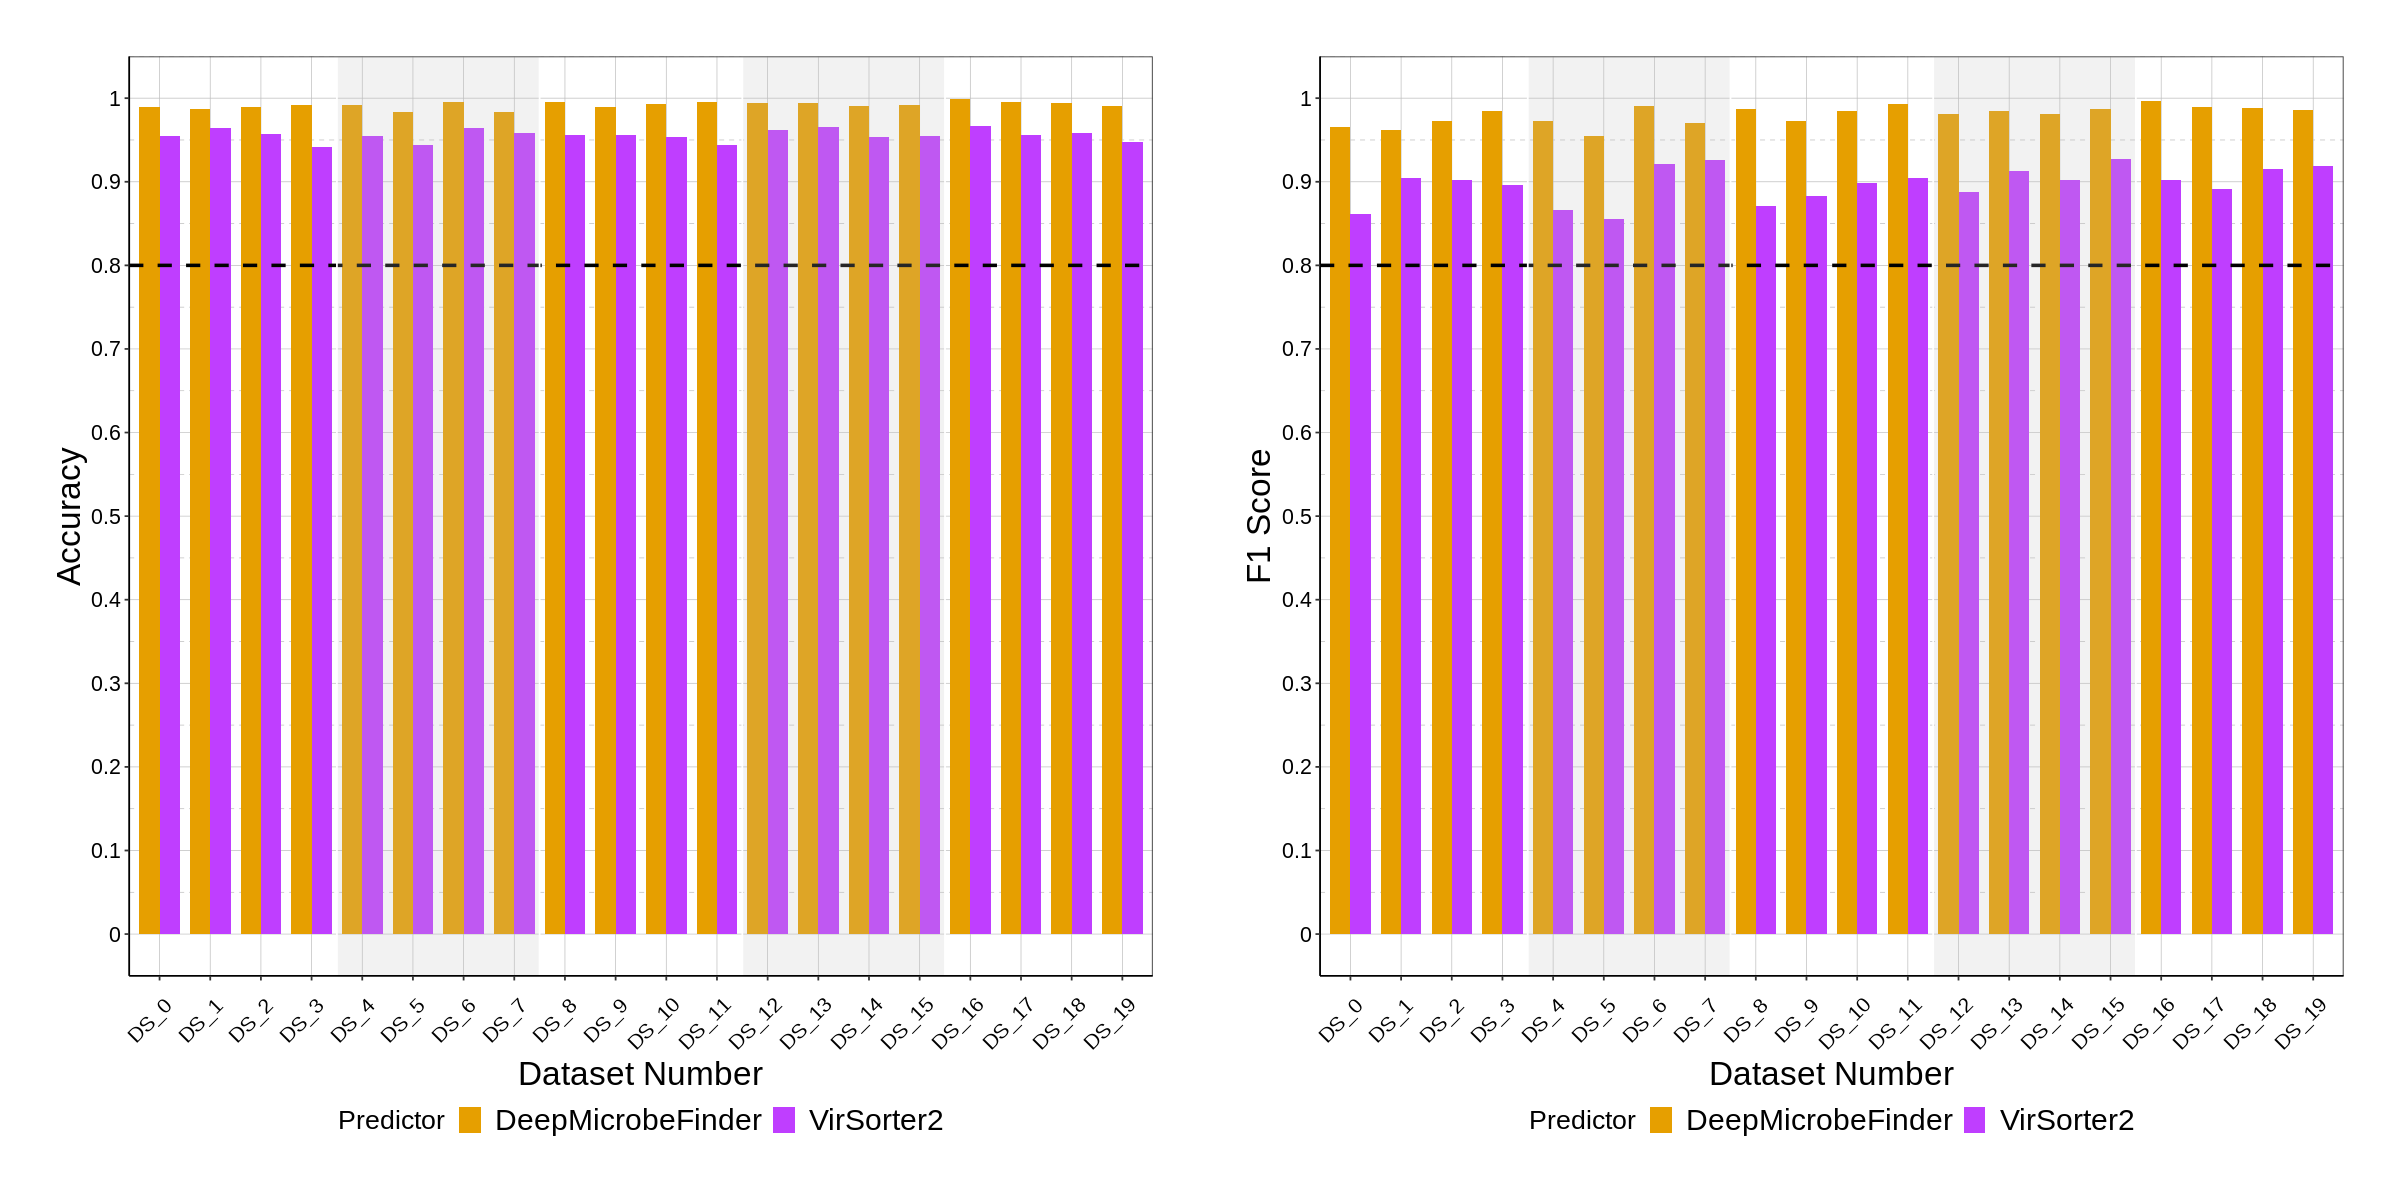

In [149]:
options(repr.plot.width=20, repr.plot.height=10)

# Virus F1 Score
vir_df_f1 <- vir_df %>% 
  select(Dataset_No, DMF_F1, VirSorter_F1) %>% 
  tidyr::gather(-Dataset_No, key = "Predictor", value = "F1Score")
# head(vir_df_f1, 2)

blind_colors <- c("#E69F00", "darkorchid1", "aquamarine3","#0072B2", "#D55E00", "#CC79A7", "#000000")

p_vir_f1 <- ggplot(data = vir_df_f1, aes(x=Dataset_No, y=F1Score, fill=Predictor)) + 
  geom_bar(width=0.8, position = "dodge", stat="identity") +
  scale_fill_manual(name = "Predictor", values=blind_colors, labels = c("DeepMicrobeFinder", "VirSorter2")) + 
  scale_y_continuous(breaks = seq(0, 1, 0.1), labels = seq(0,1,0.1)) +  
  geom_hline(yintercept=0.8, linetype="dashed", size=1, color = "black") +
  labs(x="Dataset Number", y="F1 Score") + 
  coord_cartesian(ylim = c(0, 1)) +
  theme_bw() + 
  geom_rect(data=rects_2, mapping=aes(xmin=xmin, xmax=xmax, ymin = -Inf, ymax = Inf), fill="grey", color="white", alpha = 0.2, inherit.aes = FALSE) +
  theme(panel.background = element_blank(), 
        axis.line = element_line(colour = "black"), 
        text = element_text(size = 16),
        axis.title.x = element_text(size=20, color="black", vjust=-1), 
        axis.title.y = element_text(size=20, color="black"), 
        axis.text.x = element_text(angle = 45, hjust = 0.8, vjust=0.6, color="black"), 
        axis.text.y = element_text(angle = 0, color="black"), 
        panel.grid.minor.x = element_line(colour = "grey", size=0.2, linetype = 'dashed'), 
        panel.grid.major.x = element_line(colour = "grey", size=0.2),
        panel.grid.minor.y = element_line(colour = "grey", size = 0.2, linetype = 'dashed'),
        panel.grid.major.y = element_line(colour = "grey", size=0.2),
        legend.position = "bottom", 
        legend.text=element_text(size=18), 
        legend.key.size = unit(1,"line"), 
        plot.margin=unit(c(1,1,1,1),"cm"))

# Virus Accuracy
vir_df_acc <- vir_df %>% 
  select(Dataset_No, DMF_Acc, VirSorter_Acc) %>% 
  tidyr::gather(-Dataset_No, key = "Predictor", value = "Accuracy")
# head(vir_df_acc, 2)

p_vir_acc <- ggplot(data = vir_df_acc, aes(x=Dataset_No, y=Accuracy, fill=Predictor)) + 
  geom_bar(width=0.8, position = "dodge", stat="identity") +
  scale_fill_manual(name = "Predictor", values=blind_colors, labels = c("DeepMicrobeFinder", "VirSorter2")) + 
  scale_y_continuous(breaks = seq(0, 1, 0.1), labels = seq(0,1,0.1)) +  
  geom_hline(yintercept=0.8, linetype="dashed", size=1, color = "black") +
  labs(x="Dataset Number", y="Accuracy") + 
  coord_cartesian(ylim = c(0, 1)) +
  theme_bw() + 
  geom_rect(data=rects_2, mapping=aes(xmin=xmin, xmax=xmax, ymin = -Inf, ymax = Inf), fill="grey", color="white", alpha = 0.2, inherit.aes = FALSE) +
  theme(panel.background = element_blank(), 
        axis.line = element_line(colour = "black"), 
        text = element_text(size = 16),
        axis.title.x = element_text(size=20, color="black", vjust=-1), 
        axis.title.y = element_text(size=20, color="black"), 
        axis.text.x = element_text(angle = 45, hjust = 0.8, vjust=0.6, color="black"), 
        axis.text.y = element_text(angle = 0, color="black"), 
        panel.grid.minor.x = element_line(colour = "grey", size=0.2, linetype = 'dashed'), 
        panel.grid.major.x = element_line(colour = "grey", size=0.2),
        panel.grid.minor.y = element_line(colour = "grey", size = 0.2, linetype = 'dashed'),
        panel.grid.major.y = element_line(colour = "grey", size=0.2),
        legend.position = "bottom", 
        legend.text=element_text(size=18), 
        legend.key.size = unit(1,"line"), 
        plot.margin=unit(c(1,1,1,1),"cm"))

p_vir_bar <- p_vir_acc + p_vir_f1
p_vir_bar

ggsave(filename="DMF_VirSorter_Vir_comparison_barplot.svg", # useDingbats=FALSE, 
       plot = last_plot(), path=res_dir, 
       scale = 1, width = 400, height = 200, units = "mm",
       dpi = 300, limitsize = FALSE)

### - Compare means of accuracy and F1 score by Wilcoxon

Warning message in wilcox.test.default(c(0.99000999000999, 0.987, 0.989, 0.992, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.99000999000999, 0.987, 0.989, 0.992, :
“cannot compute exact p-value with ties”


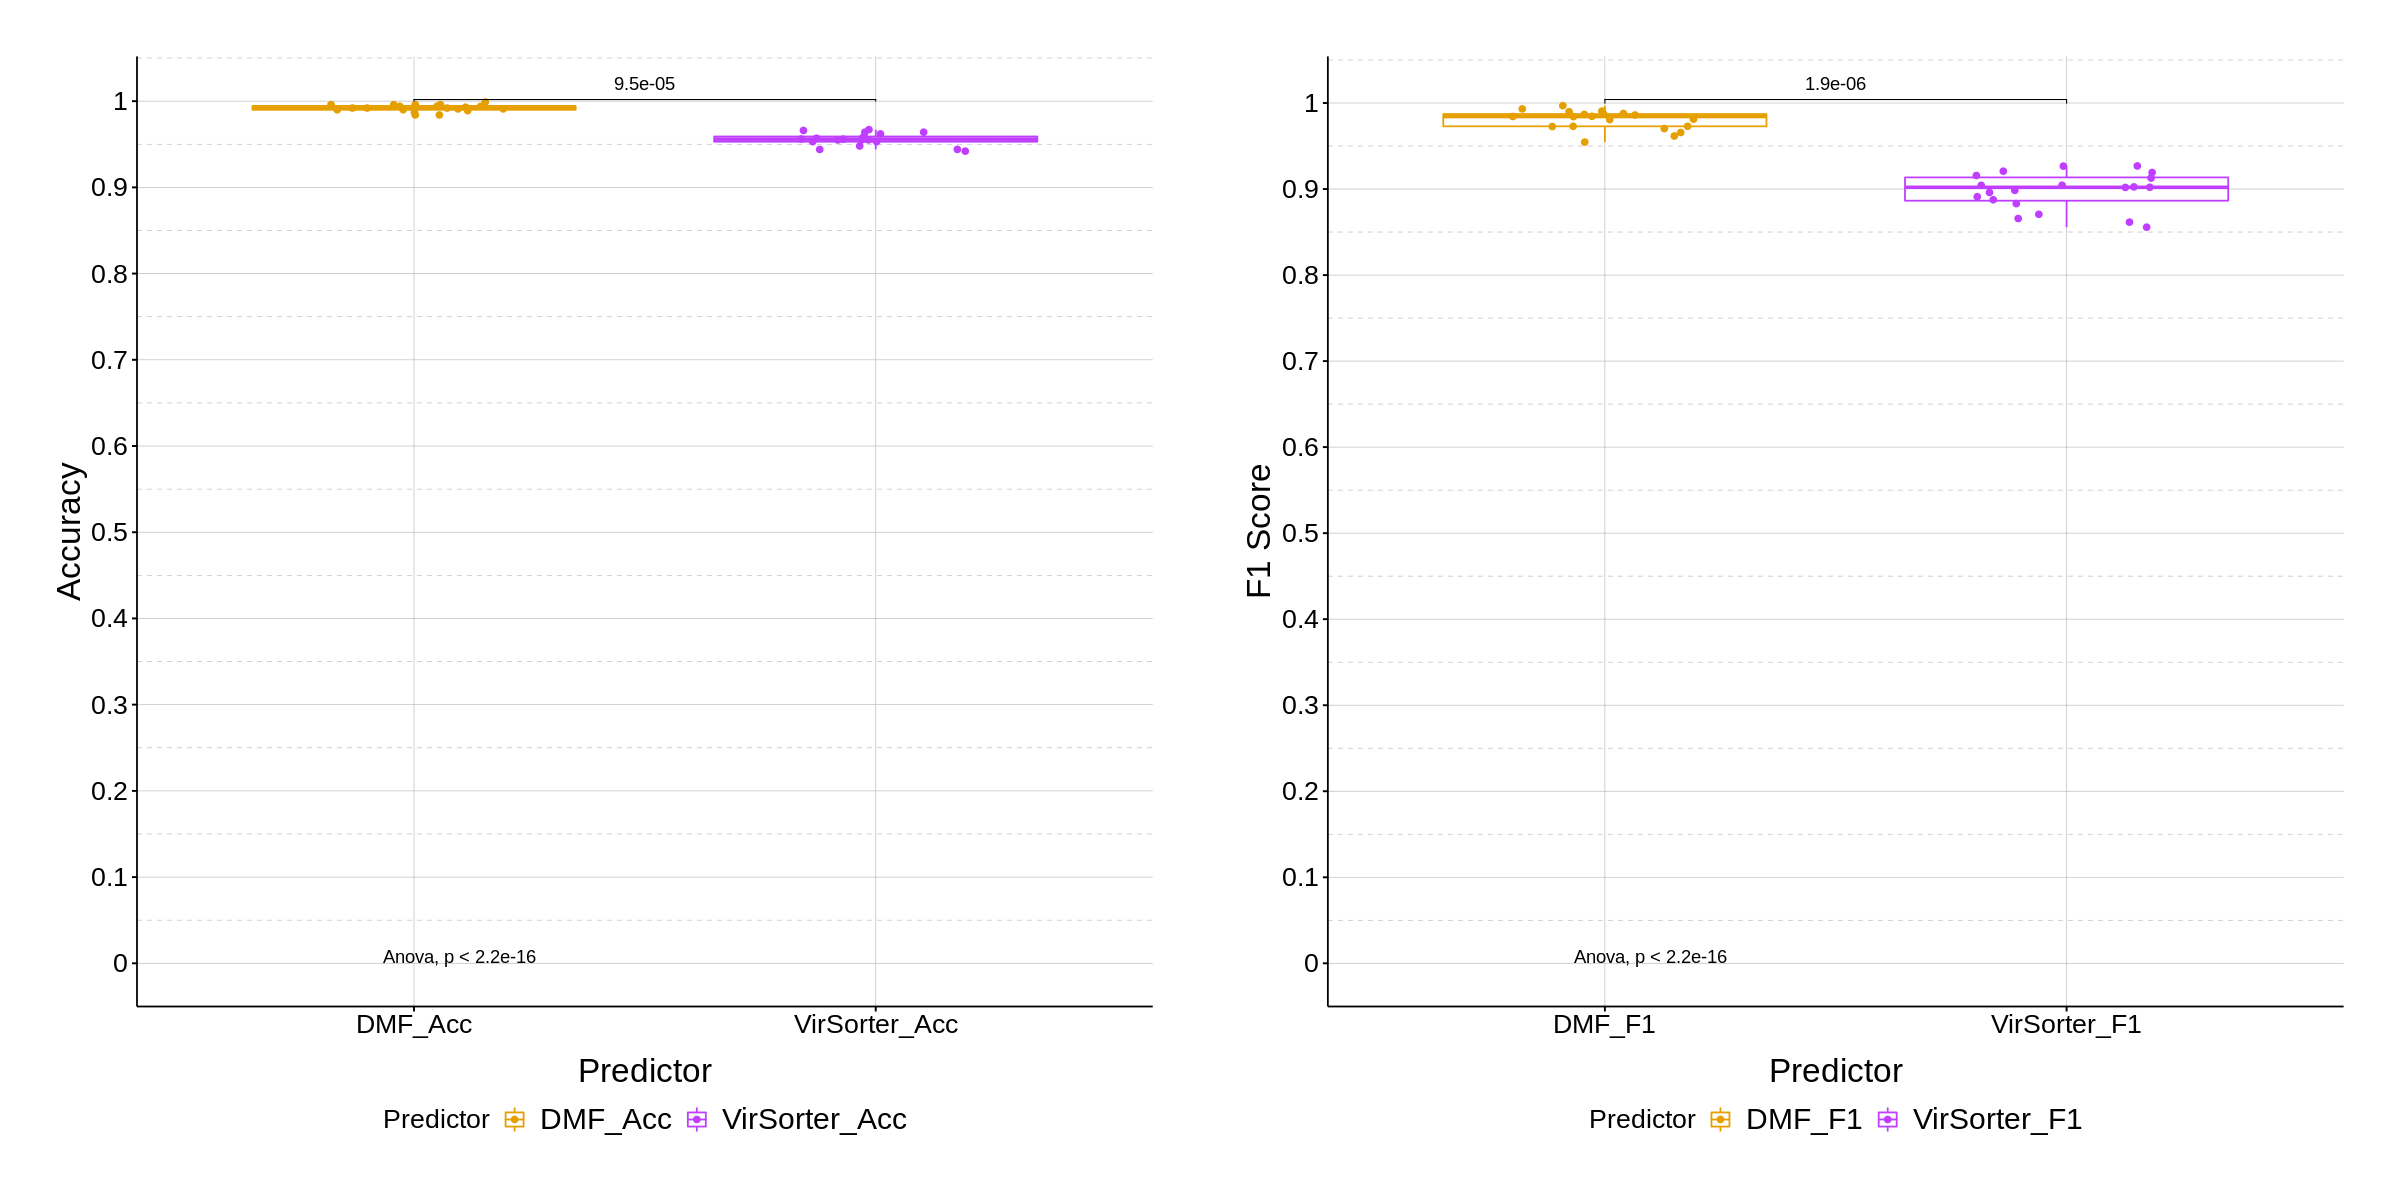

In [150]:
options(repr.plot.width=20, repr.plot.height=10)

#blind_colors <- c("orange2", "darkorchid1", "aquamarine3","blue", "vermillion", "purple", "black")
blind_colors <- c("#E69F00", "darkorchid1", "aquamarine3","#0072B2", "#D55E00", "#CC79A7", "#000000")

my_comparisons <- list(c("DMF_Acc", "VirSorter_Acc"))
p_vir_acc_box <- ggboxplot(vir_df_acc, x = "Predictor", y = "Accuracy",
          color = "Predictor", palette = blind_colors, add = "jitter") + 
  stat_compare_means(comparisons = my_comparisons,  method = "wilcox.test", paired = TRUE) + # Add pairwise comparisons p-value
#   stat_pvalue_manual(vir_ttest_acc, label = "p.adj") +
  stat_compare_means(method = "anova", label.y = 0.) +    # Add global p-value
  labs(x="Predictor", y="Accuracy") + 
  scale_y_continuous(breaks = seq(0, 1, 0.1), labels = seq(0,1,0.1)) +  
  theme(panel.background = element_blank(), 
        axis.line = element_line(colour = "black"), 
        text = element_text(size = 16),
        axis.title.x = element_text(size=20, color="black", vjust=-1), 
        axis.title.y = element_text(size=20, color="black"), 
        axis.text.x = element_text(angle = 0, color="black"), 
        axis.text.y = element_text(angle = 0, color="black"), 
        panel.grid.minor.x = element_line(colour = "grey", size=0.2, linetype = 'dashed'), 
        panel.grid.major.x = element_line(colour = "grey", size=0.2),
        panel.grid.minor.y = element_line(colour = "grey", size = 0.2, linetype = 'dashed'),
        panel.grid.major.y = element_line(colour = "grey", size=0.2),
        legend.position = "bottom", 
        legend.text=element_text(size=18), 
        legend.key.size = unit(1,"line"), 
        plot.margin=unit(c(1,1,1,1),"cm"))


my_comparisons <- list(c("DMF_F1", "VirSorter_F1"))
p_vir_f1_box <- ggboxplot(vir_df_f1, x = "Predictor", y = "F1Score",
         color = "Predictor", add="jitter",
         palette = blind_colors) +
  stat_compare_means(comparisons = my_comparisons,  method = "wilcox.test", paired = TRUE) + # Add pairwise comparisons p-value
#   stat_pvalue_manual(vir_ttest_f1, label = "p.adj") +
  stat_compare_means(method = "anova", label.y = 0.) +    # Add global p-value
  labs(x="Predictor", y="F1 Score") + 
  scale_y_continuous(breaks = seq(0, 1, 0.1), labels = seq(0,1,0.1)) +  
  theme(panel.background = element_blank(), 
        axis.line = element_line(colour = "black"), 
        text = element_text(size = 16),
        axis.title.x = element_text(size=20, color="black", vjust=-1), 
        axis.title.y = element_text(size=20, color="black"), 
        axis.text.x = element_text(angle = 0, color="black"), 
        axis.text.y = element_text(angle = 0, color="black"), 
        panel.grid.minor.x = element_line(colour = "grey", size=0.2, linetype = 'dashed'), 
        panel.grid.major.x = element_line(colour = "grey", size=0.2),
        panel.grid.minor.y = element_line(colour = "grey", size = 0.2, linetype = 'dashed'),
        panel.grid.major.y = element_line(colour = "grey", size=0.2),
        legend.position = "bottom", 
        legend.text=element_text(size=18), 
        legend.key.size = unit(1,"line"), 
        plot.margin=unit(c(1,1,1,1),"cm"))

p_vir_box <- p_vir_acc_box + p_vir_f1_box
p_vir_box

ggsave(filename="DMF_VirSorter_Vir_comparison_boxplot.svg", # useDingbats=FALSE, 
       plot = last_plot(), path=res_dir, 
       scale = 1, width = 400, height = 200, units = "mm",
       dpi = 300, limitsize = FALSE)

# Comparison of multiclass Classification

In [151]:
# DeepMicrobeFinder multiclass summarized in classes of PPR
df_dmf_multi <- df_dmf %>% filter(category == "multiclass")
df_dmf_multi <- df_dmf_multi[match(dataset_order_names, df_dmf_multi$filename),]
rownames(df_dmf_multi) <- seq(0, 19)
head(df_dmf_multi, 2)

# PPR-Meta multiclass
df_ppr_multi <- df_ppr[match(dataset_order_names, df_ppr$filename),]
rownames(df_ppr_multi) <- seq(0, 19)
head(df_ppr_multi, 2)

# merge DeepMicrobeFinder, PlasFlow and PPR-Meta
multi_df <- cbind(df_dmf_multi[, c("f1_score", "accuracy")], df_ppr_multi[, c("f1_score", "accuracy")]) 
colnames(multi_df) <- c("DMF_F1", "DMF_Acc", "PPR_F1", "PPR_Acc")
ds_order <- paste("DS", rownames(multi_df), sep = "_")
multi_df$Dataset_No = factor(ds_order, levels=ds_order) 
head(multi_df, 2)


,filename,category,f1_score,accuracy
,<chr>,<chr>,<dbl>,<dbl>
0,643_129_129_83_17,multiclass,0.9620121,0.961039
1,600_150_150_80_20,multiclass,0.9559455,0.955000


,filename,f1_score,accuracy
,<chr>,<dbl>,<dbl>
0,643_129_129_83_17,0.01019812,0.05494505
1,600_150_150_80_20,0.01016083,0.05400000


,DMF_F1,DMF_Acc,PPR_F1,PPR_Acc,Dataset_No
,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0,0.9620121,0.961039,0.01019812,0.05494505,DS_0
1,0.9559455,0.955000,0.01016083,0.05400000,DS_1


### - plot accuracy and F1 score for DMF and PPR

,Dataset_No,Predictor,F1Score
,<fct>,<chr>,<dbl>
1,DS_0,DMF_F1,0.9620121
2,DS_1,DMF_F1,0.9559455


,Dataset_No,Predictor,Accuracy
,<fct>,<chr>,<dbl>
1,DS_0,DMF_Acc,0.961039
2,DS_1,DMF_Acc,0.955000


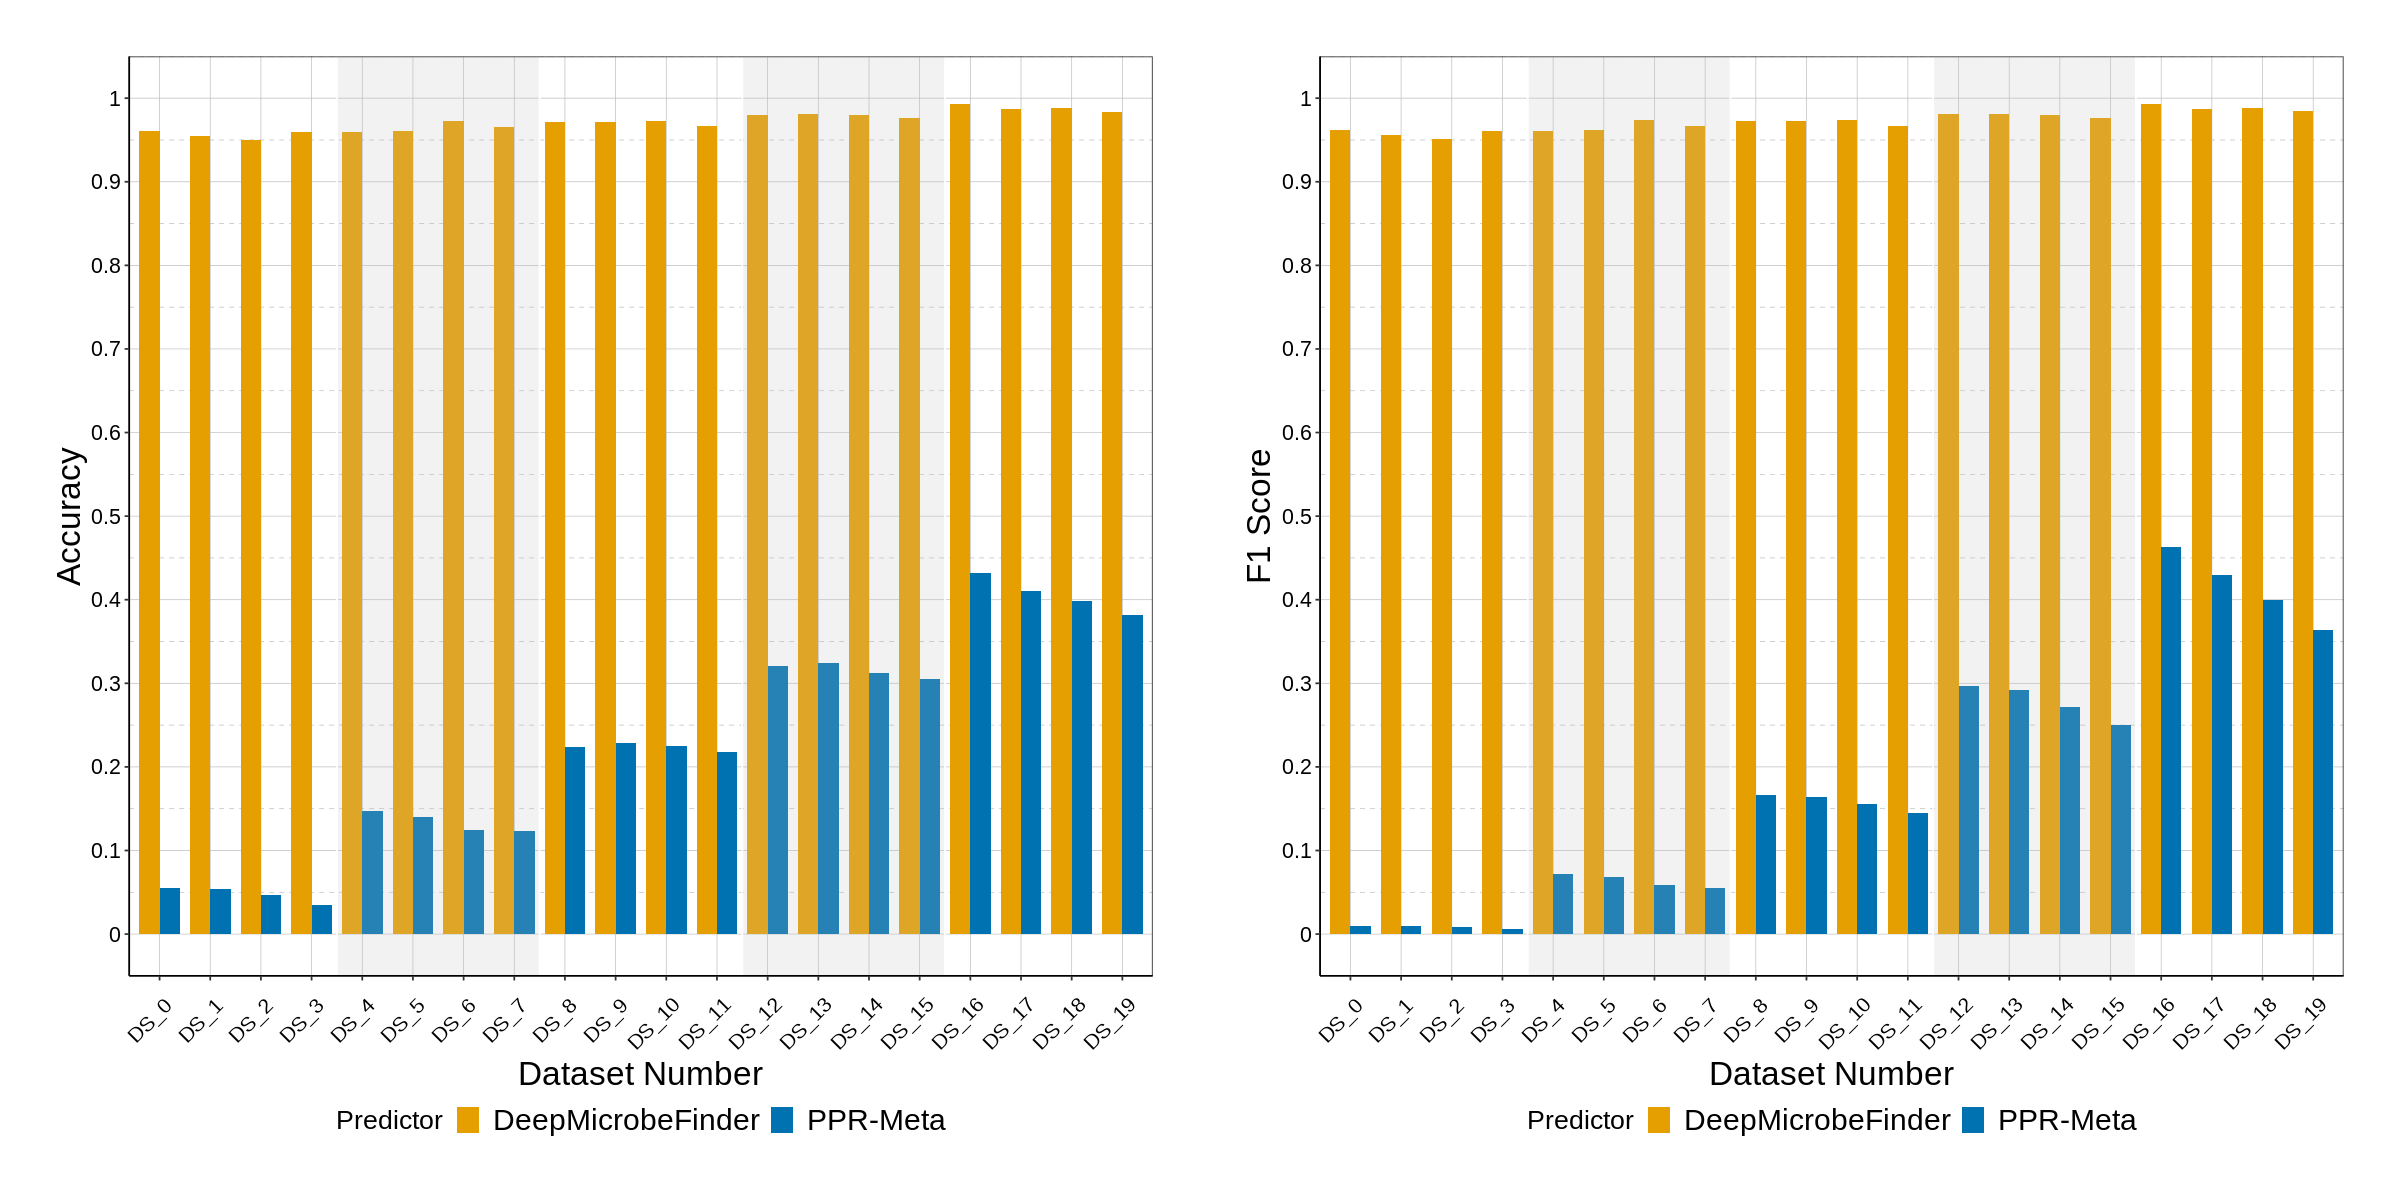

In [152]:
options(repr.plot.width=20, repr.plot.height=10)

# multiclass F1 Score
multi_df_f1 <- multi_df %>% 
  select(Dataset_No, DMF_F1, PPR_F1) %>% 
  tidyr::gather(-Dataset_No, key = "Predictor", value = "F1Score")
head(multi_df_f1, 2)

#blind_colors <- c("orange2", "blue", "vermillion", "purple", "black")
blind_colors <- c("#E69F00", "#0072B2", "#D55E00", "#CC79A7", "#000000")

p_multi_f1 <- ggplot(data = multi_df_f1, aes(x=Dataset_No, y=F1Score, fill=Predictor)) + 
  geom_bar(width=0.8, position = "dodge", stat="identity") +
  scale_fill_manual(name = "Predictor", values=blind_colors, labels = c("DeepMicrobeFinder", "PPR-Meta")) + 
  scale_y_continuous(breaks = seq(0, 1, 0.1), labels = seq(0,1,0.1)) +  
  labs(x="Dataset Number", y="F1 Score") +
  coord_cartesian(ylim = c(0, 1)) + 
  theme_bw() + 
  geom_rect(data=rects_2, mapping=aes(xmin=xmin, xmax=xmax, ymin = -Inf, ymax = Inf), fill="grey", color="white", alpha = 0.2, inherit.aes = FALSE) +
  theme(panel.background = element_blank(), 
        axis.line = element_line(colour = "black"), 
        text = element_text(size = 16),
        axis.title.x = element_text(size=20, color="black", vjust=-1), 
        axis.title.y = element_text(size=20, color="black"), 
        axis.text.x = element_text(angle = 45, hjust = 0.8, vjust=0.6, color="black"), 
        axis.text.y = element_text(angle = 0, color="black"), 
        panel.grid.minor.x = element_line(colour = "grey", size=0.2, linetype = 'dashed'), 
        panel.grid.major.x = element_line(colour = "grey", size=0.2),
        panel.grid.minor.y = element_line(colour = "grey", size = 0.2, linetype = 'dashed'),
        panel.grid.major.y = element_line(colour = "grey", size=0.2),
        legend.position = "bottom", 
        legend.text=element_text(size=18), 
        legend.key.size = unit(1,"line"), 
        plot.margin=unit(c(1,1,1,1),"cm"))

# multiclass Accuracy
multi_df_acc <- multi_df %>% 
  select(Dataset_No, DMF_Acc, PPR_Acc) %>% 
  tidyr::gather(-Dataset_No, key = "Predictor", value = "Accuracy")
head(multi_df_acc, 2)

p_multi_acc <- ggplot(data = multi_df_acc, aes(x=Dataset_No, y=Accuracy, fill=Predictor)) + 
  geom_bar(width=0.8, position = "dodge", stat="identity") +
  scale_fill_manual(name = "Predictor", values=blind_colors, labels = c("DeepMicrobeFinder", "PPR-Meta")) + 
  scale_y_continuous(breaks = seq(0, 1, 0.1), labels = seq(0,1,0.1)) +  
  labs(x="Dataset Number", y="Accuracy") +
  coord_cartesian(ylim = c(0, 1)) + 
  theme_bw() + 
  geom_rect(data=rects_2, mapping=aes(xmin=xmin, xmax=xmax, ymin = -Inf, ymax = Inf), fill="grey", color="white", alpha = 0.2, inherit.aes = FALSE) +
  theme(panel.background = element_blank(), 
        axis.line = element_line(colour = "black"), 
        text = element_text(size = 16),
        axis.title.x = element_text(size=20, color="black", vjust=-1), 
        axis.title.y = element_text(size=20, color="black"), 
        axis.text.x = element_text(angle = 45, hjust = 0.8, vjust=0.6, color="black"), 
        axis.text.y = element_text(angle = 0, color="black"), 
        panel.grid.minor.x = element_line(colour = "grey", size=0.2, linetype = 'dashed'), 
        panel.grid.major.x = element_line(colour = "grey", size=0.2),
        panel.grid.minor.y = element_line(colour = "grey", size = 0.2, linetype = 'dashed'),
        panel.grid.major.y = element_line(colour = "grey", size=0.2),
        legend.position = "bottom", 
        legend.text=element_text(size=18), 
        legend.key.size = unit(1,"line"), 
        plot.margin=unit(c(1,1,1,1),"cm"))

p_multi_bar <- p_multi_acc + p_multi_f1
p_multi_bar

ggsave(filename="DMF_PPR_MultiClass_comparison_barplot.svg", # useDingbats=FALSE, 
       plot = last_plot(), path=res_dir, 
       scale = 1, width = 400, height = 200, units = "mm",
       dpi = 300, limitsize = FALSE)

### t-test on accuracy and F1 score

In [153]:
# # t-test Accuracy
# t.test(Accuracy ~ Predictor, data = multi_df_acc)

# # t-test F1 Scores
# t.test(F1Score ~ Predictor, data = multi_df_f1)

### - compare means of accuracy and F1 score by t-test

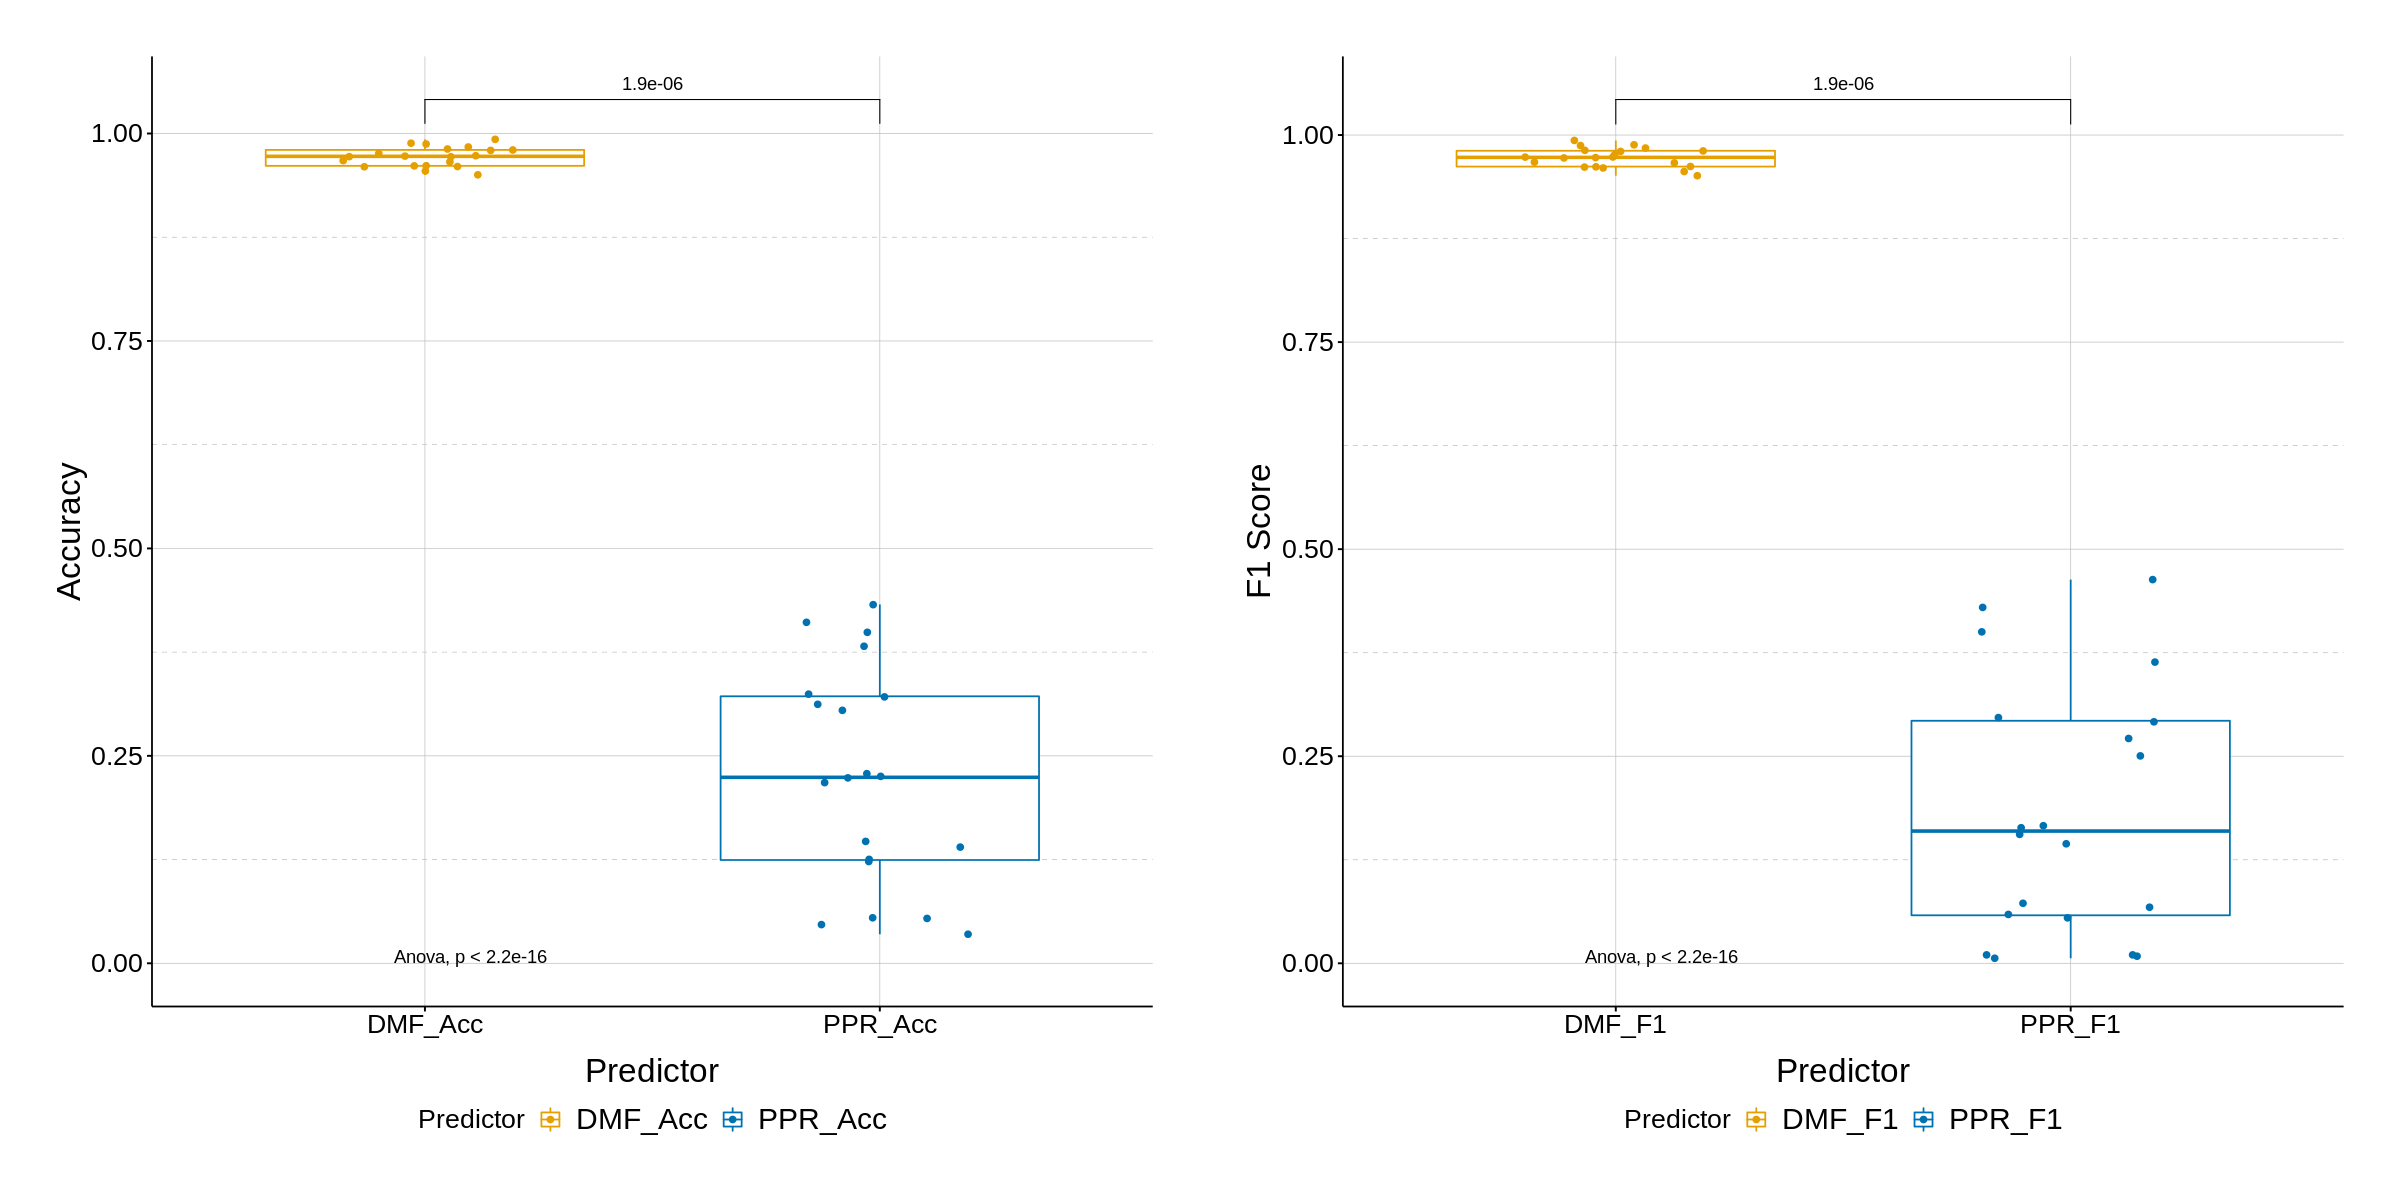

In [154]:
options(repr.plot.width=20, repr.plot.height=10)

#blind_colors <- c("orange2", "blue", "vermillion", "purple", "black")
blind_colors <- c("#E69F00", "#0072B2", "#D55E00", "#CC79A7", "#000000")

my_comparisons <- list(c("DMF_Acc", "PPR_Acc"))
p_multi_acc_box <- ggboxplot(multi_df_acc, x = "Predictor", y = "Accuracy",
          color = "Predictor", palette = blind_colors, add = "jitter") + 
  #stat_compare_means(comparisons = my_comparisons,  method = "t.test") + # Add pairwise comparisons p-value
  stat_compare_means(comparisons = my_comparisons,  method = "wilcox.test", paired=TRUE) + # Add pairwise comparisons p-value
  #stat_compare_means(label.y = 0.5) +    # Add global p-value
  stat_compare_means(method = "anova", label.y = 0.) +    # Add global p-value
  labs(x="Predictor", y="Accuracy") + 
  theme(panel.background = element_blank(), 
        axis.line = element_line(colour = "black"), 
        text = element_text(size = 16),
        axis.title.x = element_text(size=20, color="black", vjust=-1), 
        axis.title.y = element_text(size=20, color="black"), 
        axis.text.x = element_text(angle = 0, color="black"), 
        axis.text.y = element_text(angle = 0, color="black"), 
        panel.grid.minor.x = element_line(colour = "grey", size=0.2, linetype = 'dashed'), 
        panel.grid.major.x = element_line(colour = "grey", size=0.2),
        panel.grid.minor.y = element_line(colour = "grey", size = 0.2, linetype = 'dashed'),
        panel.grid.major.y = element_line(colour = "grey", size=0.2),
        legend.position = "bottom", 
        legend.text=element_text(size=18), 
        legend.key.size = unit(1,"line"), 
        plot.margin=unit(c(1,1,1,1),"cm"))

my_comparisons <- list(c("DMF_F1", "PPR_F1"))
p_multi_f1_box <- ggboxplot(multi_df_f1, x = "Predictor", y = "F1Score",
         color = "Predictor", add="jitter",
         palette = blind_colors) +
  #stat_compare_means(comparisons = my_comparisons,  method = "t.test") + # Add pairwise comparisons p-value
  stat_compare_means(comparisons = my_comparisons,  method = "wilcox.test", paired=TRUE) + # Add pairwise comparisons p-value
  #stat_compare_means(label.y = 0.5) +    # Add global p-value
  stat_compare_means(method = "anova", label.y = 0.) +    # Add global p-value
  labs(x="Predictor", y="F1 Score") + 
  theme(panel.background = element_blank(), 
        axis.line = element_line(colour = "black"), 
        text = element_text(size = 16),
        axis.title.x = element_text(size=20, color="black", vjust=-1), 
        axis.title.y = element_text(size=20, color="black"), 
        axis.text.x = element_text(angle = 0, color="black"), 
        axis.text.y = element_text(angle = 0, color="black"), 
        panel.grid.minor.x = element_line(colour = "grey", size=0.2, linetype = 'dashed'), 
        panel.grid.major.x = element_line(colour = "grey", size=0.2),
        panel.grid.minor.y = element_line(colour = "grey", size = 0.2, linetype = 'dashed'),
        panel.grid.major.y = element_line(colour = "grey", size=0.2),
        legend.position = "bottom", 
        legend.text=element_text(size=18), 
        legend.key.size = unit(1,"line"), 
        plot.margin=unit(c(1,1,1,1),"cm"))

p_multi_box <- p_multi_acc_box + p_multi_f1_box
p_multi_box

ggsave(filename="DMF_PPR_MultiClass_comparison_boxplot.svg", # useDingbats=FALSE, 
       plot = last_plot(), path=res_dir, 
       scale = 1, width = 400, height = 200, units = "mm",
       dpi = 300, limitsize = FALSE)

#### when both DMF and PPR collapse plasmid into prokaryotes, how does it look like?

In [285]:
multi_df <- cbind(df_dmf_multi[, c("f1_score", "accuracy")], df_ppr_multi[, c("f1_score", "accuracy")]) 
colnames(multi_df) <- c("DMF_F1", "DMF_Acc", "PPR_F1", "PPR_Acc")
#ds_order <- paste("DS", rownames(multi_df), sep = "_")
#multi_df$Dataset_No = factor(ds_order, levels=ds_order) 
multi_df$Dataset_No <- seq(0, 19)
head(multi_df, 2)

,DEF_F1,DEF_Acc,PPR_F1,PPR_Acc,Dataset_No
,<dbl>,<dbl>,<dbl>,<dbl>,<int>
0,0.7126784,0.6954839,0.5662299,0.5947844,0
1,0.7131644,0.7007673,0.5958840,0.6142285,1


In [286]:
options(repr.plot.width=20, repr.plot.height=10)

# multiclass F1 Score
multi_df_f1 <- multi_df %>% 
  select(Dataset_No, DMF_F1, PPR_F1) %>% 
  mutate(Partition=rep(c("9:1", "7:3", "5:5", "3:7", "1:9"), each=4)) %>% 
  tidyr::gather(-Dataset_No, -Partition, key = "Predictor", value = "F1Score") 
head(multi_df_f1, 2)

,Dataset_No,Partition,Predictor,F1Score
,<int>,<chr>,<chr>,<dbl>
1,0,9:1,DEF_F1,0.7126784
2,1,9:1,DEF_F1,0.7131644


In [287]:
multi_df_f1_par <- multi_df_f1 %>% 
  group_by(Partition, Predictor) %>% 
  slice(1, 4) %>% 
  arrange(Predictor, Dataset_No) %>% 
  mutate(pos=ifelse(Dataset_No%%2==0, "start", "end")) %>% 
  group_by(Predictor) %>% 
  spread(pos, F1Score)


multi_df_f1_par

Dataset_No,Partition,Predictor,end,start
<int>,<chr>,<chr>,<dbl>,<dbl>
0,9:1,DEF_F1,NA,0.7126784
0,9:1,PPR_F1,NA,0.5662299
3,9:1,DEF_F1,0.7025446,NA
3,9:1,PPR_F1,0.6703703,NA
4,7:3,DEF_F1,NA,0.7752724
4,7:3,PPR_F1,NA,0.4973692
7,7:3,DEF_F1,0.7555676,NA
7,7:3,PPR_F1,0.5975750,NA
8,5:5,DEF_F1,NA,0.8203433


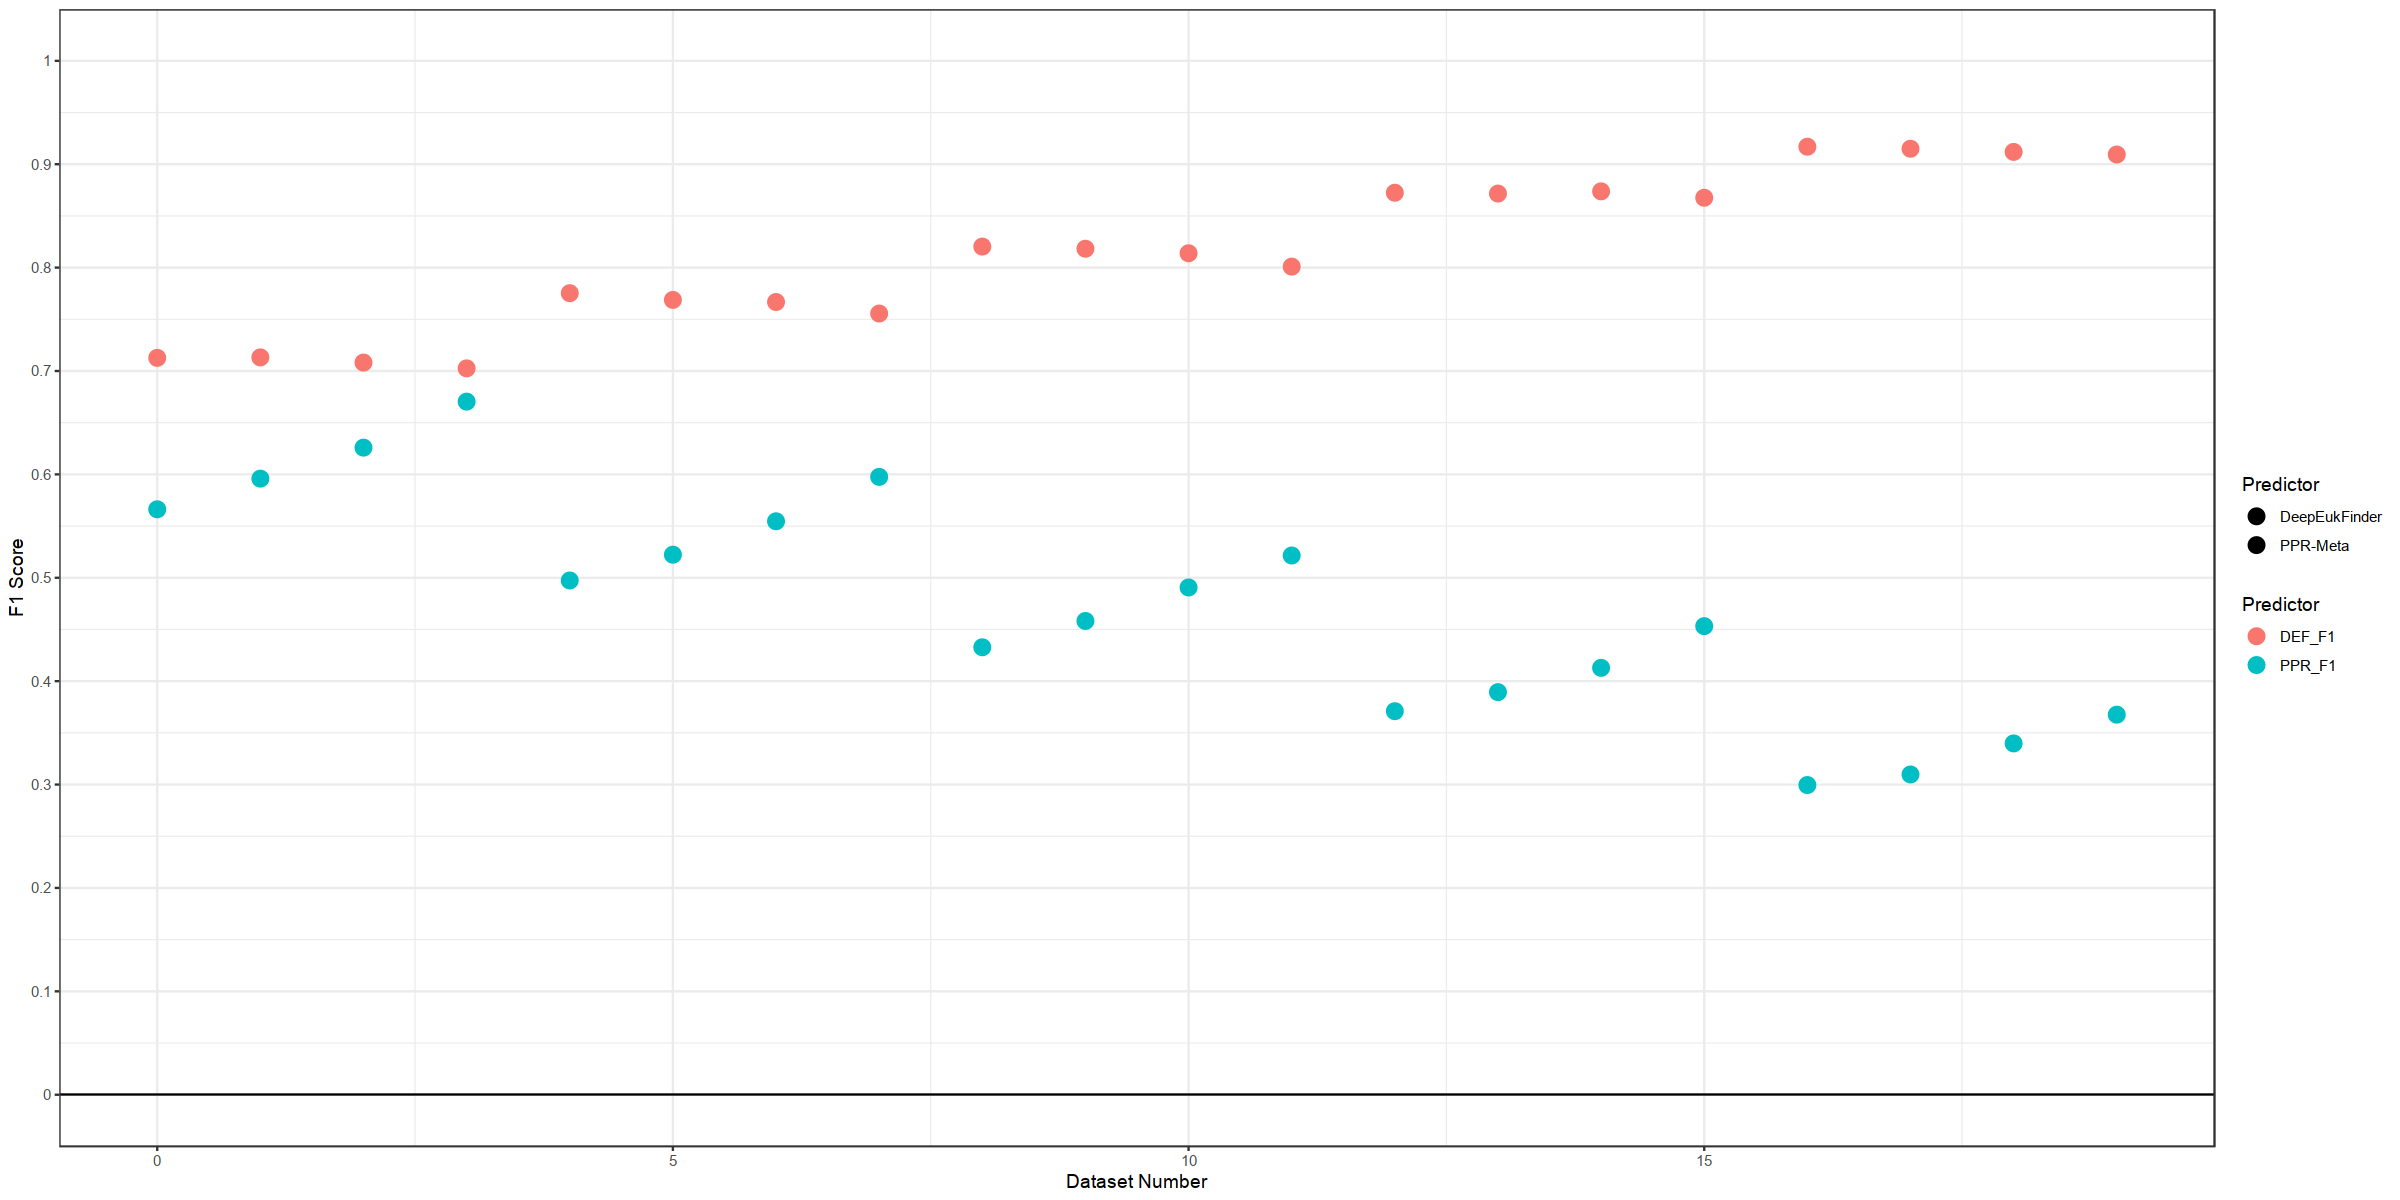

In [288]:
#blind_colors <- c("orange2", "blue", "vermillion", "purple", "black")
blind_colors <- c("#E69F00", "#0072B2", "#D55E00", "#CC79A7", "#000000")

p_multi_f1 <- ggplot(data = multi_df_f1, aes(x=Dataset_No, y=F1Score, fill=Predictor, color=Predictor)) + 
  geom_hline(aes(yintercept=0)) +
  #geom_segment(data=multi_df_f1_par, aes(x=Dataset_No,y=F1Score,xend=Dataset_No+,yend=F1Score, color=Predictor), position=position_dodge(width=0.9)) + 
  geom_point(data=multi_df_f1, aes(x=Dataset_No,y=F1Score, color=Predictor), size=4) + 
  scale_fill_manual(name = "Predictor", values=blind_colors, labels = c("DeepMicrobeFinder", "PPR-Meta")) + 
  scale_y_continuous(breaks = seq(0, 1, 0.1), labels = seq(0,1,0.1)) +  
  labs(x="Dataset Number", y="F1 Score") +
  coord_cartesian(ylim = c(0, 1)) + 
  theme_bw() 
p_multi_f1